In [27]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel


# Function to load and prepare data
def load_and_prepare_data(filepath, sort_by='timestamp', ascending=False):
    """
    Load the dataset and prepare it by setting the correct index and sorting.
    
    Parameters:
        filepath (str): The path to the CSV file.
        sort_by (str): The column to sort by, default is 'timestamp'.
        ascending (bool): Whether to sort in ascending order, default is False.
    
    Returns:
        pd.DataFrame: The prepared DataFrame.
    """
    # Load data
    data = pd.read_csv(filepath)
    
    # Convert the 'timestamp' column to datetime format
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    
    # Set 'timestamp' as the index
    data.set_index('timestamp', inplace=True)
    
    # Sort the data by timestamp (most recent entries first)
    data.sort_values(by=sort_by, ascending=ascending, inplace=True)
    
    return data

# Load and prepare the dataset
data = load_and_prepare_data('SPY_2024-08.csv')

# Inspect the first few rows to ensure correct loading and sorting
print(data.head())


                        open    high      low    close   volume
timestamp                                                      
2024-08-16 20:00:00  554.310  554.31  554.310  554.310  1440205
2024-08-16 19:59:00  553.930  553.99  553.870  553.900     2726
2024-08-16 19:58:00  553.955  553.99  553.920  553.990      226
2024-08-16 19:57:00  553.960  553.99  553.950  553.955     2172
2024-08-16 19:56:00  553.990  553.99  553.955  553.970     1047


In [28]:
from sklearn.preprocessing import MinMaxScaler

# Function to create the target variable
def create_target_variable(data, shift_by=1):
    """
    Create the target variable by shifting the close prices.
    
    Parameters:
        data (pd.DataFrame): The DataFrame containing the data.
        shift_by (int): The number of periods to shift the close prices to create the target variable.
    
    Returns:
        pd.DataFrame: The DataFrame with the new target variable.
    """
    data['close_t+1'] = data['close'].shift(shift_by)
    return data

# Function to calculate log returns and scale volume
def calculate_log_return_and_scale_volume(data, shift_by=-1):
    """
    Calculate the log returns based on shifted close prices and scale the volume.
    
    Parameters:
        data (pd.DataFrame): The DataFrame containing the data.
        shift_by (int): The number of periods to shift the close prices for log return calculation.
    
    Returns:
        pd.DataFrame: The DataFrame with the log return and scaled volume features added.
    """
    data['log_return'] = np.log(data['close'] / data['close'].shift(shift_by))
    scaler = MinMaxScaler()
    data['Scaled_Volume'] = scaler.fit_transform(data[['volume']])
    return data

# Apply these functions to the data
data = create_target_variable(data, shift_by=1)
data = calculate_log_return_and_scale_volume(data, shift_by=-1)

# Drop NaN values resulting from shifting operations
data.dropna(inplace=True)

# Inspect the first few rows to ensure everything is correct
print(data.head())


                        open    high      low    close  volume  close_t+1  \
timestamp                                                                   
2024-08-16 19:59:00  553.930  553.99  553.870  553.900    2726    554.310   
2024-08-16 19:58:00  553.955  553.99  553.920  553.990     226    553.900   
2024-08-16 19:57:00  553.960  553.99  553.950  553.955    2172    553.990   
2024-08-16 19:56:00  553.990  553.99  553.955  553.970    1047    553.955   
2024-08-16 19:55:00  553.980  553.99  553.920  553.990    1337    553.970   

                     log_return  Scaled_Volume  
timestamp                                       
2024-08-16 19:59:00   -0.000162       0.000431  
2024-08-16 19:58:00    0.000063       0.000036  
2024-08-16 19:57:00   -0.000027       0.000343  
2024-08-16 19:56:00   -0.000036       0.000165  
2024-08-16 19:55:00    0.000000       0.000211  


In [29]:
# Function to split data into training and testing sets
def split_data(data, features, target, test_size=0.2, shuffle=False):
    """
    Split the dataset into training and testing sets.
    
    Parameters:
        data (pd.DataFrame): The DataFrame containing the data.
        features (list): The list of feature column names.
        target (str): The name of the target column.
        test_size (float): The proportion of the dataset to include in the test split.
        shuffle (bool): Whether to shuffle the data before splitting.
    
    Returns:
        tuple: Splits of the dataset (X_train, X_test, y_train, y_test).
    """
    X = data[features]
    y = data[target]
    return train_test_split(X, y, test_size=test_size, shuffle=shuffle)

# Define the features and target variable
features = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume']
target = 'close_t+1'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = split_data(data, features, target, test_size=0.2, shuffle=False)

# Inspect the shapes of the training and testing sets to confirm the split
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (9198, 6)
X_test shape: (2300, 6)
y_train shape: (9198,)
y_test shape: (2300,)


In [30]:
# from sklearn.model_selection import GridSearchCV

# # Function to perform hyperparameter tuning
# def hyperparameter_tuning(X_train, y_train):
#     """
#     Perform hyperparameter tuning using GridSearchCV for Random Forest Regressor.
    
#     Parameters:
#         X_train (pd.DataFrame): The training feature set.
#         y_train (pd.Series): The training target values.
    
#     Returns:
#         dict: The best parameters found by GridSearchCV.
#         RandomForestRegressor: The best Random Forest model.
#     """
#     # Define the parameter grid
#     param_grid = {
#         'n_estimators': [100, 200, 300],
#         'max_depth': [10, 20, None],
#         'min_samples_split': [2, 5, 10],
#         'min_samples_leaf': [1, 2, 4],
#         'max_features': ['auto', 'sqrt', 'log2']
#     }
    
#     # Initialize the Random Forest Regressor
#     rfr = RandomForestRegressor(random_state=42)
    
#     # Initialize GridSearchCV
#     grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, 
#                                cv=5, n_jobs=-1, verbose=2, 
#                                scoring='neg_mean_squared_error')
    
#     # Fit GridSearchCV
#     grid_search.fit(X_train, y_train)
    
#     # Get the best parameters and model
#     best_params = grid_search.best_params_
#     best_model = grid_search.best_estimator_
    
#     return best_params, best_model

# # Perform hyperparameter tuning
# best_params, best_rfr_model = hyperparameter_tuning(X_train, y_train)

# # Print the best parameters and the best model
# print("Best Parameters Found: ", best_params)
# print("Best Random Forest Model: ", best_rfr_model)


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_rfr_results(y_train, y_train_pred, y_test, y_test_pred, feature_importances, feature_names, data, last_n=70):
    """
    Generates and displays plots for Random Forest Regressor results including:
    - Actual vs Predicted for Training and Testing data
    - Residuals for Training and Testing data
    - Feature Importances
    - Actual vs Predicted values over time for Training and Testing data
    - Actual vs Predicted values over time for the last n data points

    Parameters:
        y_train (pd.Series): Actual target values for training data.
        y_train_pred (np.ndarray): Predicted target values for training data.
        y_test (pd.Series): Actual target values for testing data.
        y_test_pred (np.ndarray): Predicted target values for testing data.
        feature_importances (np.ndarray): Feature importances from the Random Forest model.
        feature_names (list): List of feature names corresponding to the importances.
        data (pd.DataFrame): Original dataset containing the features and target.
        last_n (int): Number of last data points to plot for Actual vs Predicted over time.
    """

    # Convert feature importances to a DataFrame for plotting
    feature_importances_df = pd.DataFrame(feature_importances, index=feature_names, columns=['Importance']).sort_values('Importance', ascending=False)

    # Plotting the results
    plt.figure(figsize=(25, 12))

    # Plot 1: Predicted vs Actual for Training data
    plt.subplot(2, 3, 1)
    plt.scatter(y_train, y_train_pred, alpha=0.6)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Training Data: Actual vs Predicted')

    # Plot 2: Residuals for Training data
    plt.subplot(2, 3, 2)
    plt.scatter(y_train_pred, y_train - y_train_pred, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Training Data: Residuals')

    # Plot 3: Predicted vs Actual for Testing data
    plt.subplot(2, 3, 3)
    plt.scatter(y_test, y_test_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Testing Data: Actual vs Predicted')

    # Plot 4: Residuals for Testing data
    plt.subplot(2, 3, 4)
    plt.scatter(y_test_pred, y_test - y_test_pred, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Testing Data: Residuals')

    # Plot 5: Feature Importances
    plt.subplot(2, 3, 5)
    sns.barplot(x=feature_importances_df['Importance'], y=feature_importances_df.index)
    plt.title('Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Features')

    # Plotting the actual vs predicted values for training and testing data
    plt.subplot(2, 3, 6)

    # Plot for training data
    plt.plot(y_train.index, y_train, label='Actual - Training', color='blue', marker='o', markersize=5, linestyle='-', linewidth=2, alpha=0.7)
    plt.plot(y_train.index, y_train_pred, label='Predicted - Training', color='orange', marker='x', markersize=5, linestyle='--', linewidth=2, alpha=0.7)

    # Plot for testing data
    plt.plot(y_test.index, y_test, label='Actual - Testing', color='green', marker='o', markersize=5, linestyle='-', linewidth=2, alpha=0.7)
    plt.plot(y_test.index, y_test_pred, label='Predicted - Testing', color='red', marker='x', markersize=5, linestyle='--', linewidth=2, alpha=0.7)

    plt.title('Actual vs Predicted Values Over Time (Training and Testing Data)')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Plotting the actual vs predicted values over time for the last n data points
    plt.figure(figsize=(16, 8))

    # Select the last n data points
    time_series = data.index[-last_n:]
    y_test_actual_last_n = y_test[-last_n:]
    y_test_pred_last_n = y_test_pred[-last_n:]

    plt.plot(time_series, y_test_actual_last_n, label='Actual', color='blue', marker='o')
    plt.plot(time_series, y_test_pred_last_n, label='Predicted', color='orange', marker='o')

    plt.title(f'Actual vs Predicted values over time (Last {last_n} Data Points)')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [32]:
# Train the Random Forest model using the best hyperparameters
best_rfr_model.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = best_rfr_model.predict(X_train)
y_test_pred = best_rfr_model.predict(X_test)

# Calculate and save metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate and save metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training Data - RMSE: {train_rmse}, MAE: {train_mae}, R²: {train_r2}")
print(f"Testing Data - RMSE: {test_rmse}, MAE: {test_mae}, R²: {test_r2}")

# Store results in a dictionary
results = {
    'Model': ['Tuned Random Forest'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2]
}

# Convert the dictionary to a DataFrame and print it
results_df = pd.DataFrame(results)
print(results_df)

# Save the performance metrics to a CSV file
results_df.to_csv('tuned_model_performance_metrics.csv', index=False)


Training Data - RMSE: 0.33846472905872477, MAE: 0.11775227088841113, R²: 0.9991195897114321
Testing Data - RMSE: 0.9581169943872869, MAE: 0.39118056363974507, R²: 0.9927388155236522
                 Model  Train RMSE  Test RMSE  Train MAE  Test MAE  Train R²  \
0  Tuned Random Forest    0.338465   0.958117   0.117752  0.391181   0.99912   

    Test R²  
0  0.992739  


Cross-Validation MSEs: [53.72061987  2.36654371  0.56614778  0.39389516  0.31288678]
Mean Cross-Validation MSE: 11.47201865955058


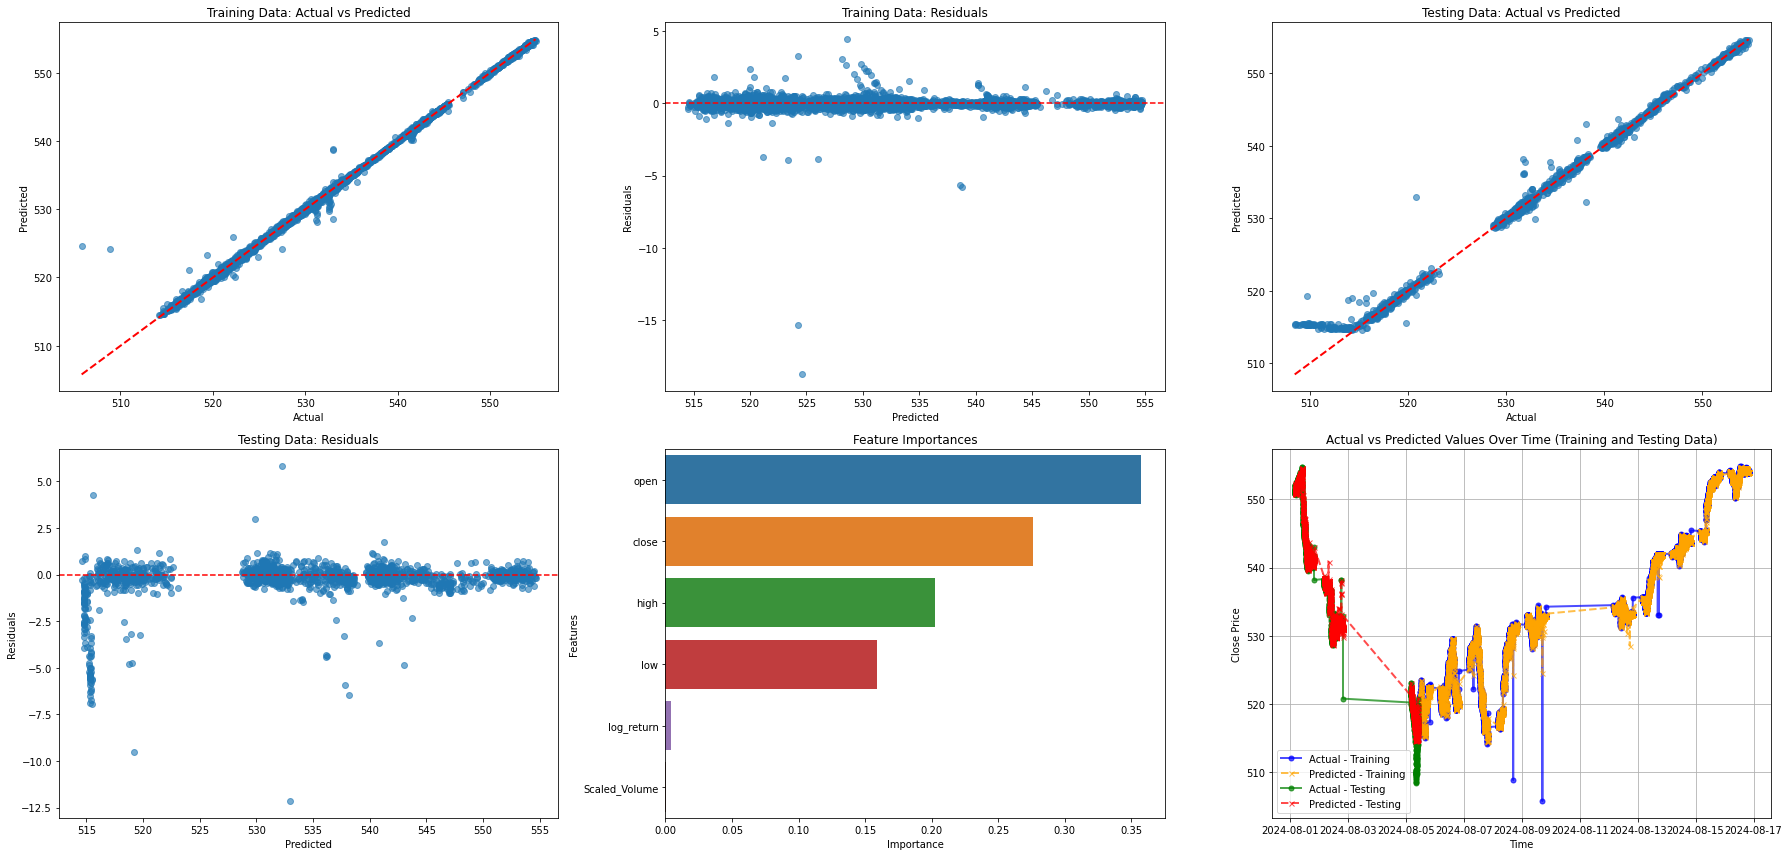

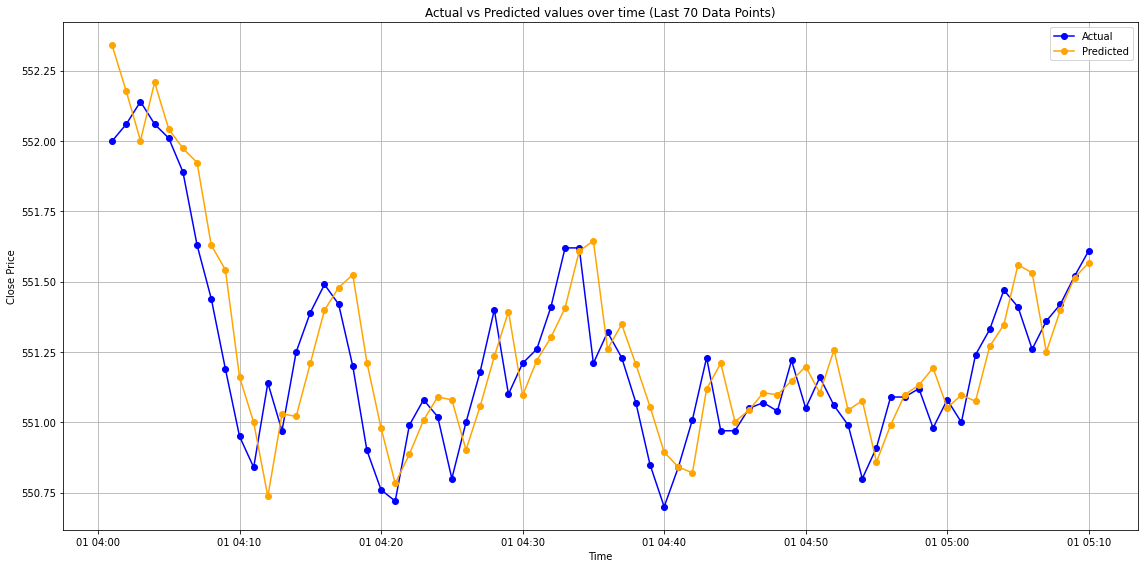

In [33]:
# Perform cross-validation for the tuned model
cv_mse = cross_val_score(best_rfr_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_mse = -cv_mse  # Convert to positive MSE

# Print the cross-validation results
print(f"Cross-Validation MSEs: {cv_mse}")
print(f"Mean Cross-Validation MSE: {cv_mse.mean()}")

# Save cross-validation results to a CSV file
cv_results_df = pd.DataFrame({
    'Fold': range(1, len(cv_mse) + 1),
    'MSE': cv_mse
})
cv_results_df.to_csv('tuned_model_cross_validation_results.csv', index=False)

# Assuming you have trained your model and made predictions
y_train_pred = best_rfr_model.predict(X_train)
y_test_pred = best_rfr_model.predict(X_test)

# Call the plot function
plot_rfr_results(
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
    feature_importances=best_rfr_model.feature_importances_,
    feature_names=X_train.columns,
    data=data,
    last_n=70  # Customize as needed
)



In [34]:
from scipy.stats import ttest_rel

def perform_stat_test(cv_mse_base, cv_mse_new, indicator_name):
    """
    Perform a paired t-test between the base model and the new model with a technical indicator.
    
    Parameters:
        cv_mse_base (np.ndarray): Cross-validation MSEs of the base model.
        cv_mse_new (np.ndarray): Cross-validation MSEs of the new model.
        indicator_name (str): Name of the technical indicator being tested.
    
    Returns:
        dict: Dictionary containing the t-statistic and p-value.
    """
    t_stat, p_value = ttest_rel(cv_mse_base, cv_mse_new)
    print(f'{indicator_name} t-statistic: {t_stat}, p-value: {p_value}')
    return {'Technical Indicator': indicator_name, 't-statistic': t_stat, 'p-value': p_value}


### Technical Indicators ###

## SMA 10

Training Data - RMSE: 0.3193505855270689, MAE: 0.10301456806196595, R²: 0.9992135672093908
Testing Data - RMSE: 0.8120166682726158, MAE: 0.3282337807697402, R²: 0.9947707917714255
SMA_10 t-statistic: 4.9441607313966225, p-value: 0.007793599106494367


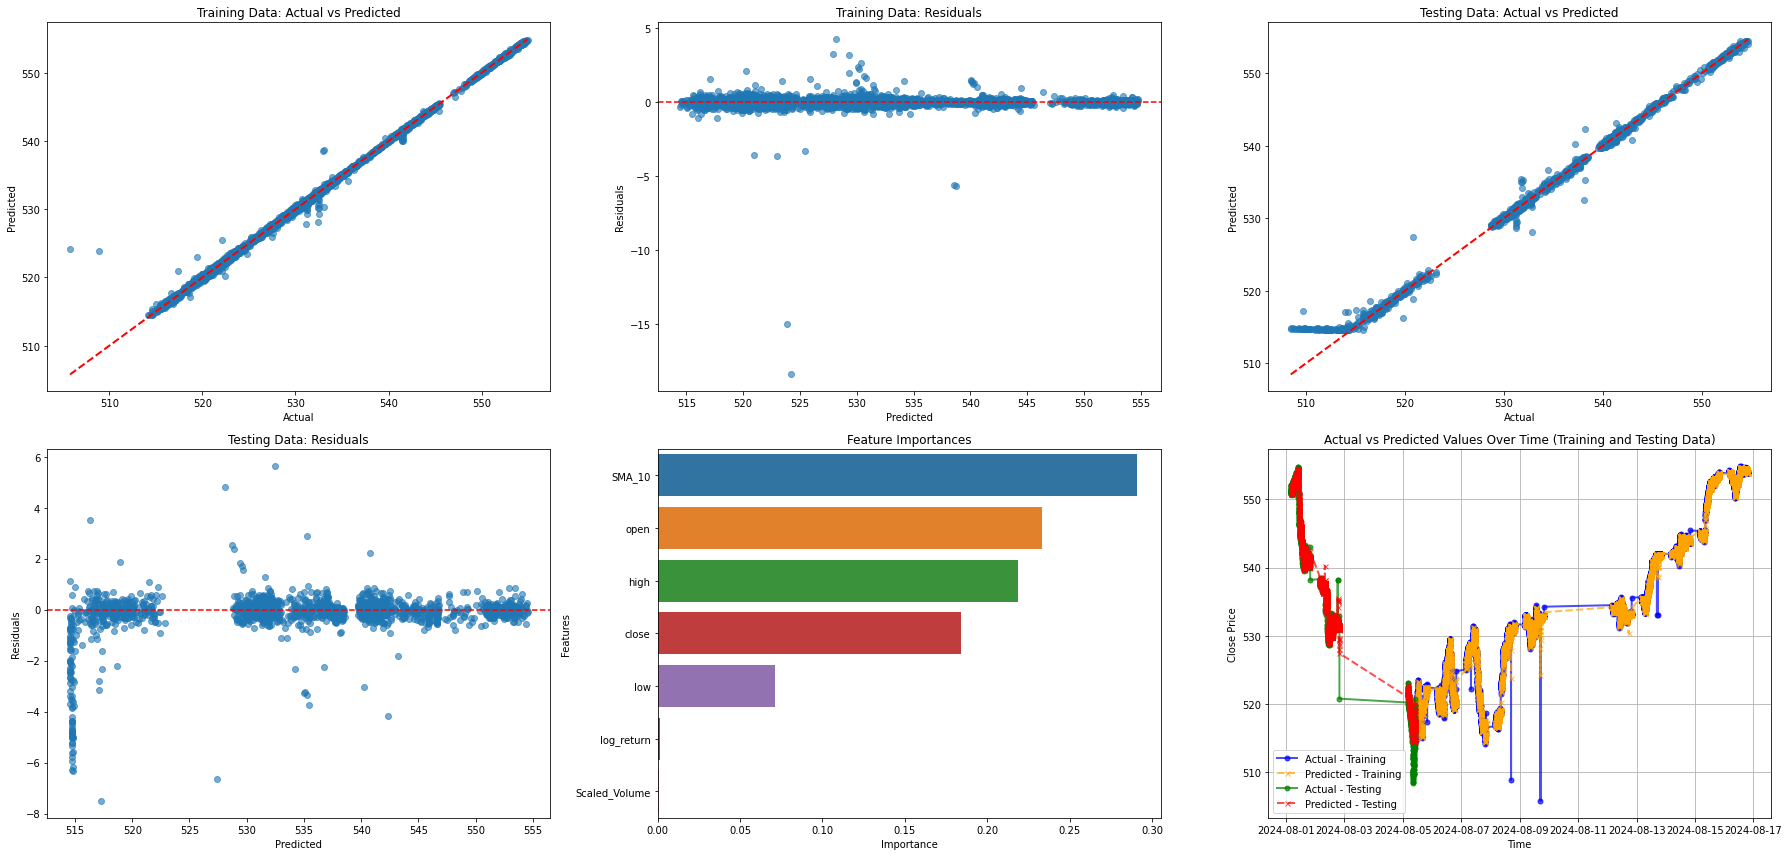

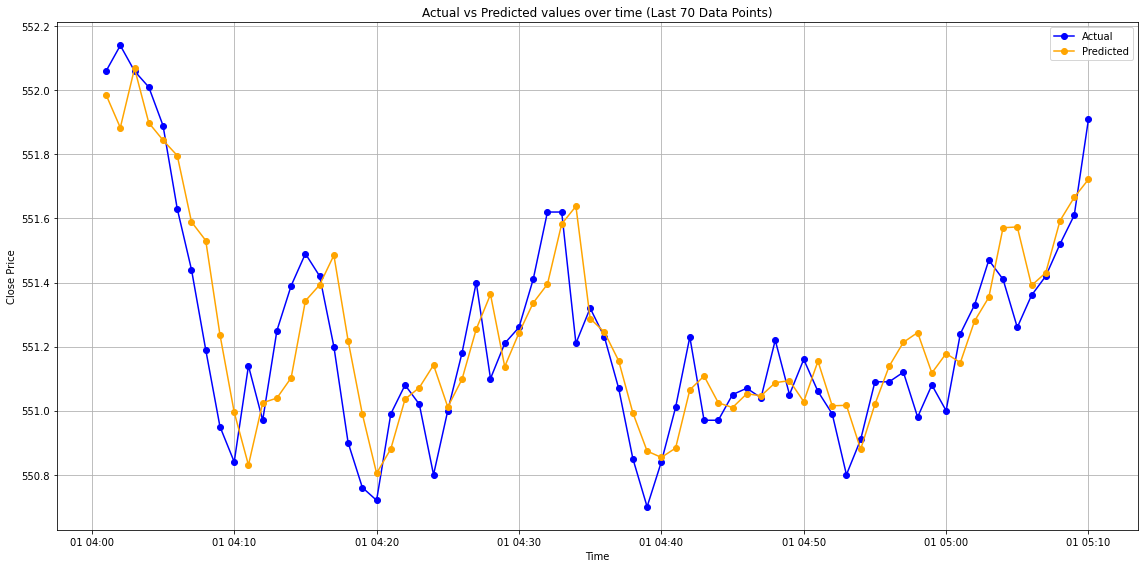

In [37]:
# Feature Engineering
data['SMA_10'] = data['close'].rolling(window=10).mean()

# Drop NaN values resulting from shift and rolling operations
data.dropna(inplace=True)

# Define the features and target variable, now including SMA_10
features_sma10 = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume', 'SMA_10']
X = data[features_sma10]
y = data['close_t+1']  # Target variable, already defined earlier

# Align features with the target
X = X[:-1]
y = y[:-1]

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model on the training data using the best parameters from hyperparameter tuning
best_rfr_model.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = best_rfr_model.predict(X_train)
y_test_pred = best_rfr_model.predict(X_test)

# Calculate metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training Data - RMSE: {train_rmse}, MAE: {train_mae}, R²: {train_r2}")
print(f"Testing Data - RMSE: {test_rmse}, MAE: {test_mae}, R²: {test_r2}")

# Perform cross-validation for the model with SMA_10
cv_mse_sma = cross_val_score(best_rfr_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_sma = -cv_mse_sma  # Convert to positive MSE

# Ensure cv_mse_base is defined for statistical comparison
if 'cv_mse_base' not in globals():
    # Assuming the base model was trained using the same features minus SMA_10
    features_base = ['open', 'high', 'low', 'close', 'log_return']
    X_base = data[features_base]
    y_base = data['close_t+1'][:-1]  # Align the target with the features
    
    # Align X_base with y_base by dropping the last row of X_base
    X_base = X_base[:-1]  # Drop the last row to match the length of y_base

    # Perform cross-validation for the base model
    cv_mse_base = cross_val_score(best_rfr_model, X_base, y_base, cv=5, scoring='neg_mean_squared_error')
    cv_mse_base = -cv_mse_base  # Convert to positive MSE

# Perform cross-validation for the model with SMA_10
cv_mse_sma = cross_val_score(best_rfr_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_sma = -cv_mse_sma  # Convert to positive MSE

# Perform statistical testing between the base model and SMA_10 model
stat_test_result = perform_stat_test(cv_mse_base, cv_mse_sma, 'SMA_10')

# Store the result for later analysis
if 't_test_results' not in globals():
    t_test_results = []
t_test_results.append(stat_test_result)


# Feature Importance
feature_importances = best_rfr_model.feature_importances_

# Plotting the results using the previously defined plot function
plot_rfr_results(
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
    feature_importances=feature_importances,
    feature_names=features_sma10,
    data=data,
    last_n=70  # Customize as needed
)

# Save the results and cross-validation MSE to CSV for future reference
results_df = pd.DataFrame({
    'Model': ['SMA_10 Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2]
})
results_df.to_csv('sma10_model_performance_metrics.csv', index=False)

cv_results_df = pd.DataFrame({
    'Fold': range(1, len(cv_mse_sma) + 1),
    'MSE': cv_mse_sma
})
cv_results_df.to_csv('sma10_model_cross_validation_results.csv', index=False)


## RSI

Training Data - RMSE: 0.34323364473638357, MAE: 0.11756480933367004, R²: 0.9990913572159507
Testing Data - RMSE: 0.9631659855293458, MAE: 0.39396531346254066, R²: 0.9926428718371202
RSI t-statistic: -1.917849206293788, p-value: 0.1275870683708547


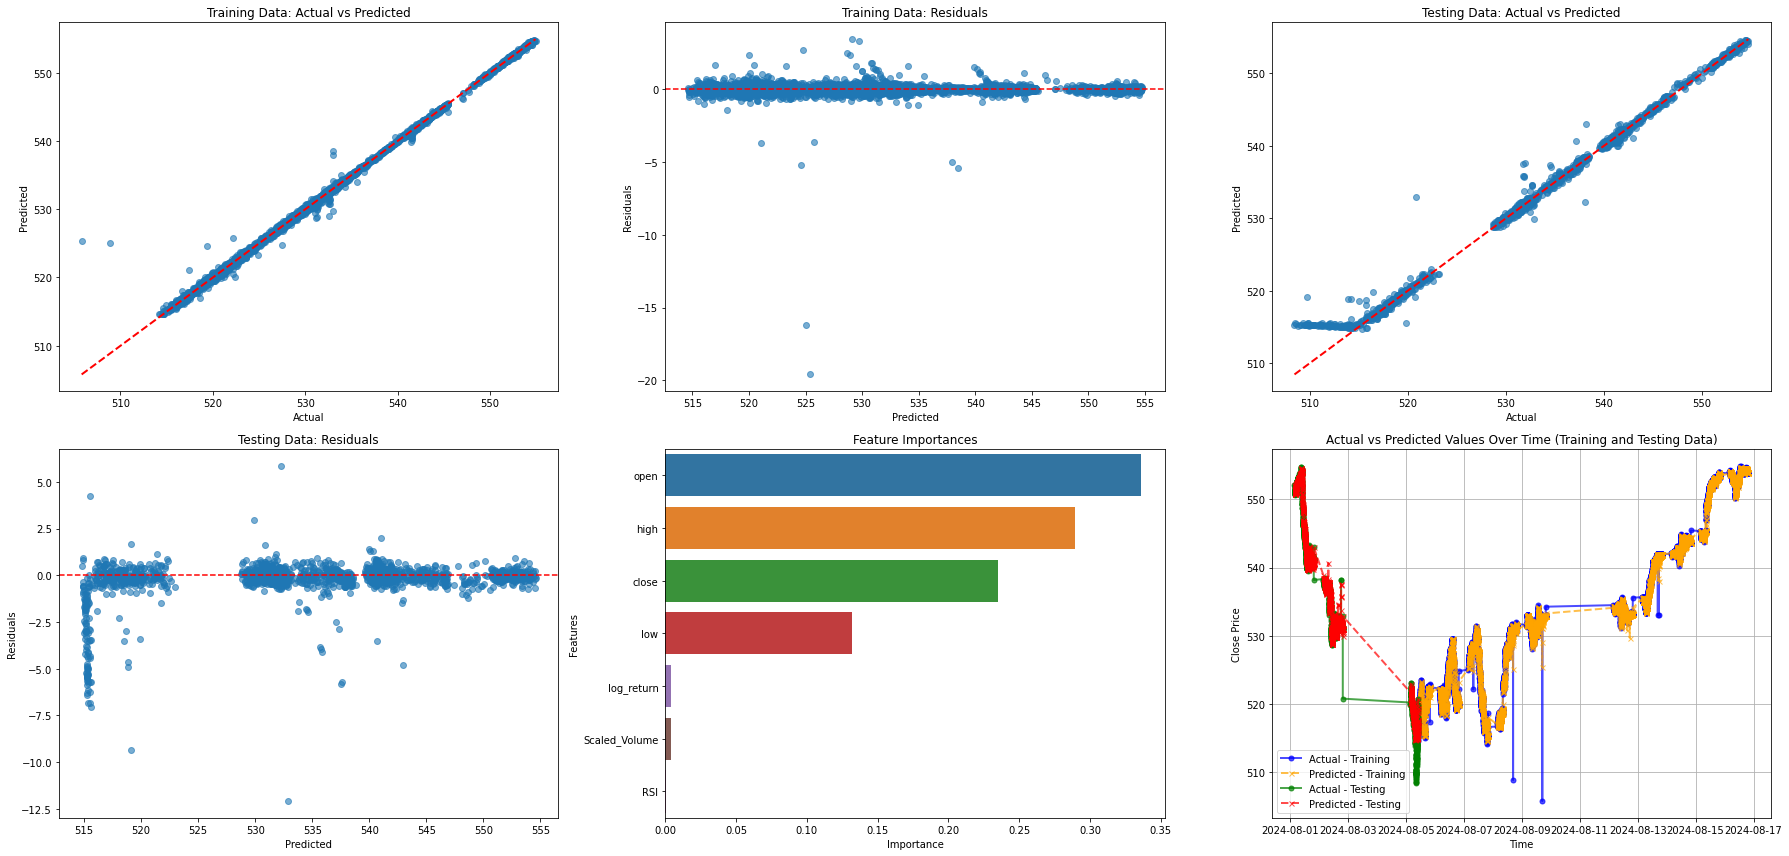

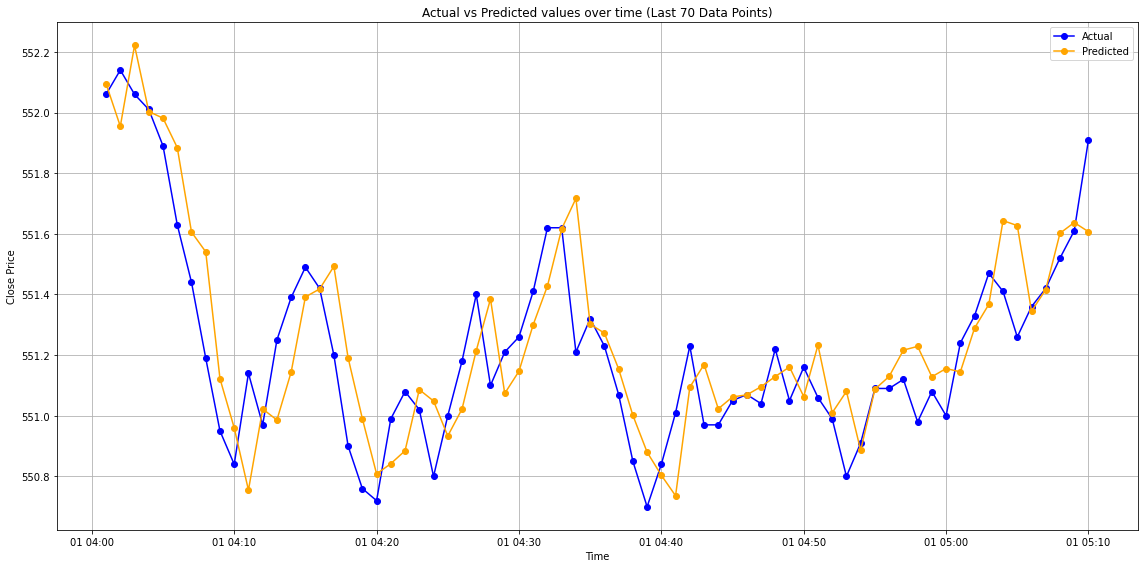

In [38]:
# Feature Engineering
window_length = 14

# Calculate daily price changes
delta = data['close'].diff()

# Make the positive gains (up) and negative gains (down) Series
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

# Calculate the average gain and loss
avg_gain = gain.rolling(window=window_length, min_periods=1).mean()
avg_loss = loss.rolling(window=window_length, min_periods=1).mean()

# Calculate RS (Relative Strength) and RSI
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))

# Drop NaN values resulting from the RSI calculation
data.dropna(inplace=True)

# Define the features and target variable, now including RSI
features_rsi = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume', 'RSI']
X = data[features_rsi]
y = data['close_t+1']  # Target variable, already defined earlier

# Align features with the target
X = X[:-1]
y = y[:-1]

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model on the training data using the best parameters from hyperparameter tuning
best_rfr_model.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = best_rfr_model.predict(X_train)
y_test_pred = best_rfr_model.predict(X_test)

# Calculate metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training Data - RMSE: {train_rmse}, MAE: {train_mae}, R²: {train_r2}")
print(f"Testing Data - RMSE: {test_rmse}, MAE: {test_mae}, R²: {test_r2}")

# Perform cross-validation for the model with RSI
cv_mse_rsi = cross_val_score(best_rfr_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_rsi = -cv_mse_rsi  # Convert to positive MSE

# Ensure cv_mse_base is defined for statistical comparison
if 'cv_mse_base' not in globals():
    # Assuming the base model was trained using the same features minus RSI
    features_base = ['open', 'high', 'low', 'close', 'log_return']
    X_base = data[features_base]
    y_base = data['close_t+1'][:-1]  # Align the target with the features
    
    # Align X_base with y_base by dropping the last row of X_base
    X_base = X_base[:-1]  # Drop the last row to match the length of y_base

    # Perform cross-validation for the base model
    cv_mse_base = cross_val_score(best_rfr_model, X_base, y_base, cv=5, scoring='neg_mean_squared_error')
    cv_mse_base = -cv_mse_base  # Convert to positive MSE

# Perform statistical testing between the base model and RSI model
stat_test_result = perform_stat_test(cv_mse_base, cv_mse_rsi, 'RSI')

# Store the result for later analysis
if 't_test_results' not in globals():
    t_test_results = []
t_test_results.append(stat_test_result)

# Feature Importance
feature_importances = best_rfr_model.feature_importances_

# Plotting the results using the previously defined plot function
plot_rfr_results(
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
    feature_importances=feature_importances,
    feature_names=features_rsi,
    data=data,
    last_n=70  # Customize as needed
)

# Save the results and cross-validation MSE to CSV for future reference
results_df = pd.DataFrame({
    'Model': ['RSI Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2]
})
results_df.to_csv('rsi_model_performance_metrics.csv', index=False)

cv_results_df = pd.DataFrame({
    'Fold': range(1, len(cv_mse_rsi) + 1),
    'MSE': cv_mse_rsi
})
cv_results_df.to_csv('rsi_model_cross_validation_results.csv', index=False)


## EMA 10

Training Data - RMSE: 0.30190743683568855, MAE: 0.09723611386631904, R²: 0.9992969906518148
Testing Data - RMSE: 0.873303796013856, MAE: 0.3523758660107609, R²: 0.9939516523814393
EMA_10 t-statistic: 1.9064232829468024, p-value: 0.12927775752882226


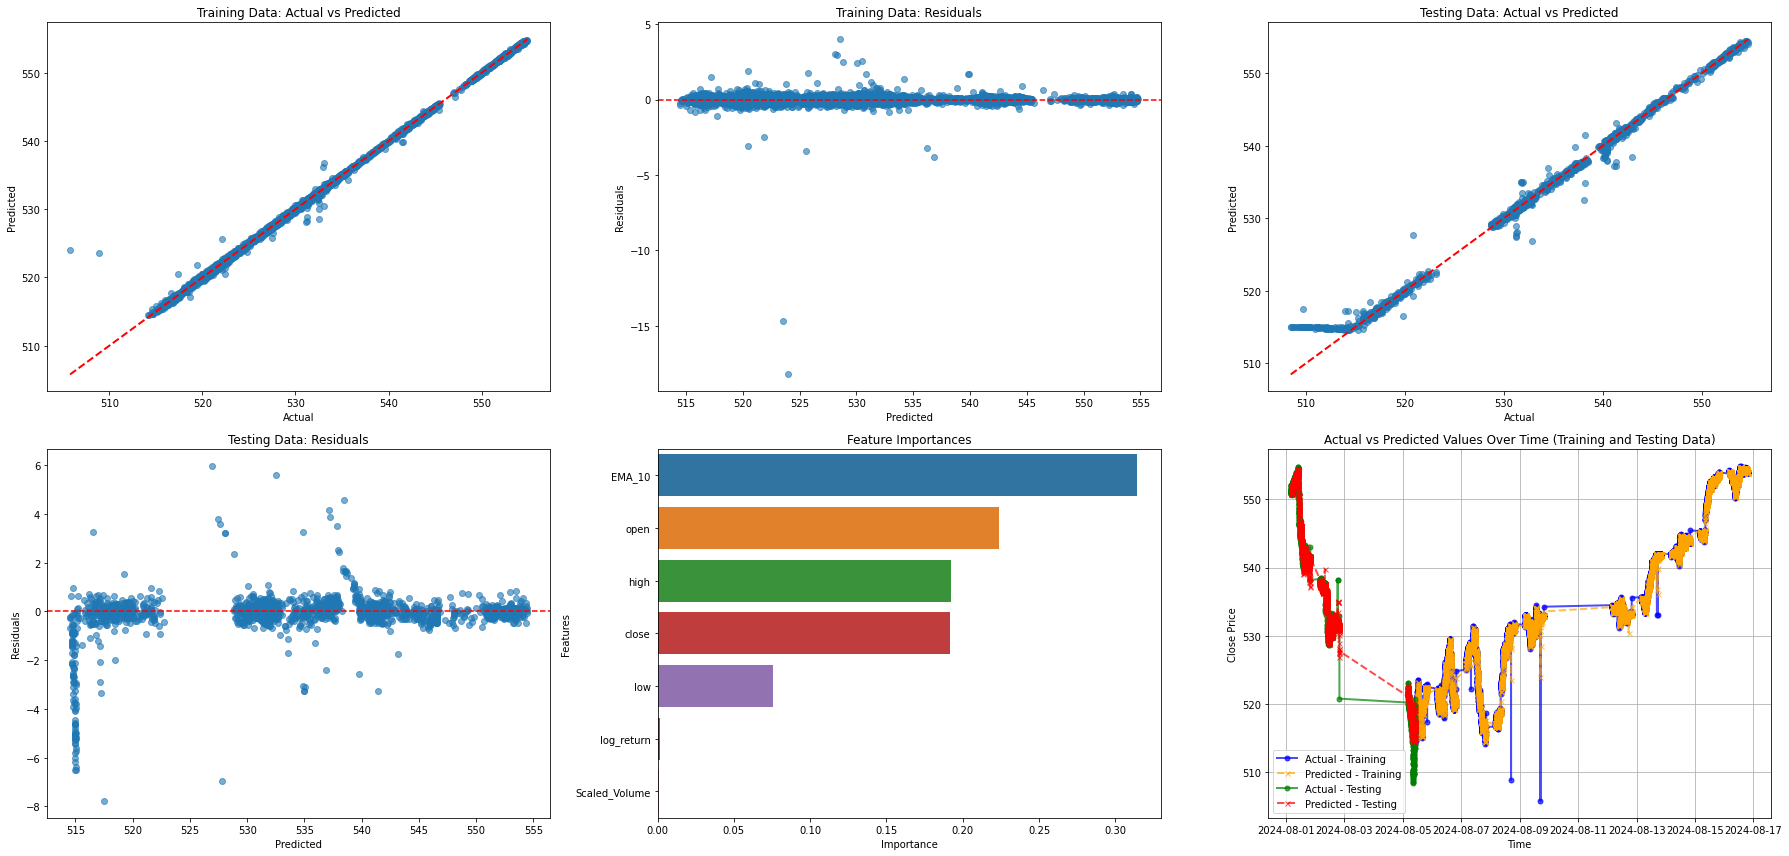

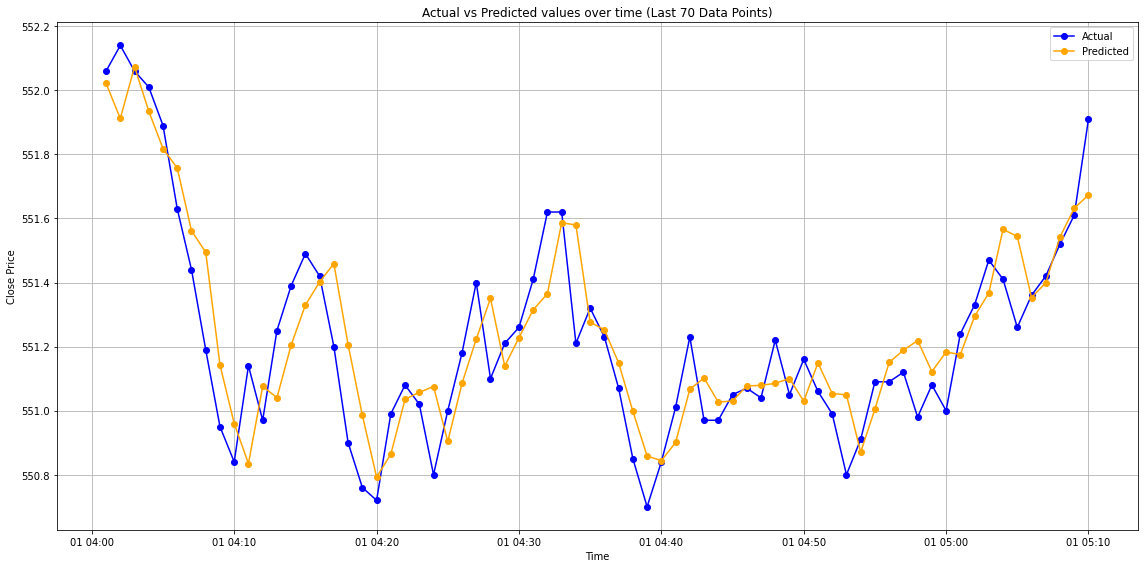

In [39]:
# Feature Engineering
data['EMA_10'] = data['close'].ewm(span=10, adjust=False).mean()

# Drop NaN values resulting from shift and rolling operations
data.dropna(inplace=True)

# Define the features and target variable, now including EMA_10
features_ema10 = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume', 'EMA_10']
X = data[features_ema10]
y = data['close_t+1']  # Target variable, already defined earlier

# Align features with the target
X = X[:-1]
y = y[:-1]

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model on the training data using the best parameters from hyperparameter tuning
best_rfr_model.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = best_rfr_model.predict(X_train)
y_test_pred = best_rfr_model.predict(X_test)

# Calculate metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training Data - RMSE: {train_rmse}, MAE: {train_mae}, R²: {train_r2}")
print(f"Testing Data - RMSE: {test_rmse}, MAE: {test_mae}, R²: {test_r2}")

# Perform cross-validation for the model with EMA_10
cv_mse_ema = cross_val_score(best_rfr_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_ema = -cv_mse_ema  # Convert to positive MSE

# Ensure cv_mse_base is defined for statistical comparison
if 'cv_mse_base' not in globals():
    # Assuming the base model was trained using the same features minus EMA_10
    features_base = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume']
    X_base = data[features_base]
    y_base = data['close_t+1'][:-1]  # Align the target with the features
    
    # Align X_base with y_base by dropping the last row of X_base
    X_base = X_base[:-1]  # Drop the last row to match the length of y_base

    # Perform cross-validation for the base model
    cv_mse_base = cross_val_score(best_rfr_model, X_base, y_base, cv=5, scoring='neg_mean_squared_error')
    cv_mse_base = -cv_mse_base  # Convert to positive MSE

# Perform statistical testing between the base model and EMA_10 model
stat_test_result = perform_stat_test(cv_mse_base, cv_mse_ema, 'EMA_10')

# Store the result for later analysis
if 't_test_results' not in globals():
    t_test_results = []
t_test_results.append(stat_test_result)

# Feature Importance
feature_importances = best_rfr_model.feature_importances_

# Plotting the results using the previously defined plot function
plot_rfr_results(
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
    feature_importances=feature_importances,
    feature_names=features_ema10,
    data=data,
    last_n=70  # Customize as needed
)

# Save the results and cross-validation MSE to CSV for future reference
results_df = pd.DataFrame({
    'Model': ['EMA_10 Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2]
})
results_df.to_csv('ema10_model_performance_metrics.csv', index=False)

cv_results_df = pd.DataFrame({
    'Fold': range(1, len(cv_mse_ema) + 1),
    'MSE': cv_mse_ema
})
cv_results_df.to_csv('ema10_model_cross_validation_results.csv', index=False)


## MACD

Training Data - RMSE: 0.32381578983228837, MAE: 0.11211975694793905, R²: 0.9991912588863502
Testing Data - RMSE: 0.9379221904279236, MAE: 0.4003578353972316, R²: 0.9930234667287449
MACD t-statistic: -2.12508658261693, p-value: 0.10076340080847798


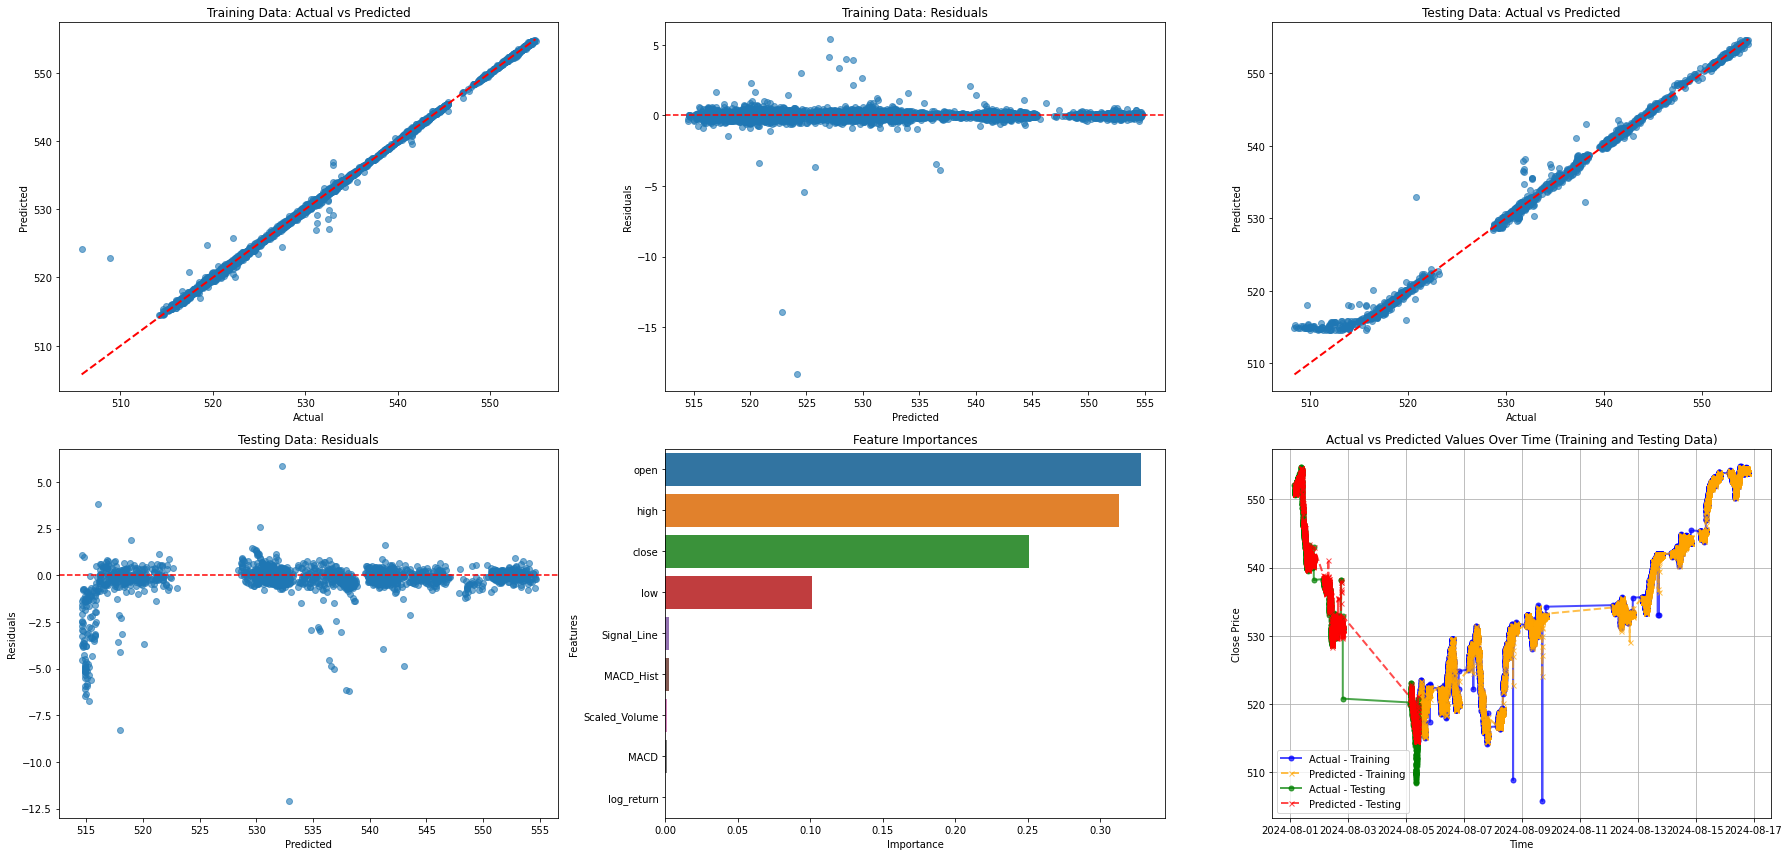

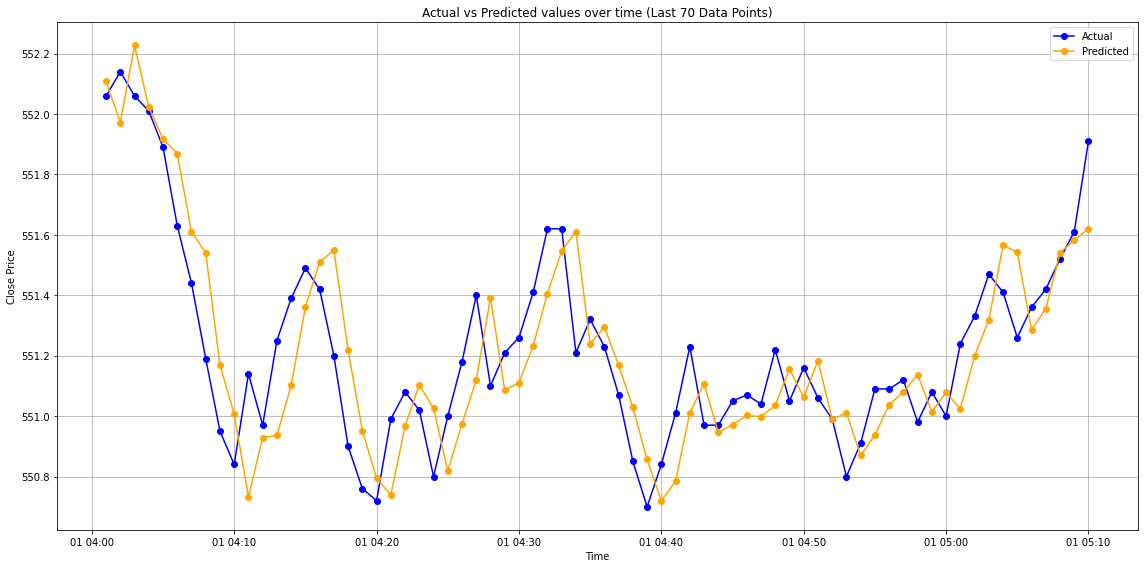

In [40]:
# Feature Engineering
data['EMA_12'] = data['close'].ewm(span=12, adjust=False).mean()
data['EMA_26'] = data['close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA_12'] - data['EMA_26']
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()
data['MACD_Hist'] = data['MACD'] - data['Signal_Line']

# Drop NaN values resulting from the MACD calculations
data.dropna(inplace=True)

# Define the features and target variable, now including MACD-related features
features_macd = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume', 'MACD', 'Signal_Line', 'MACD_Hist']
X = data[features_macd]
y = data['close_t+1']  # Target variable, already defined earlier

# Align features with the target
X = X[:-1]
y = y[:-1]

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model on the training data using the best parameters from hyperparameter tuning
best_rfr_model.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = best_rfr_model.predict(X_train)
y_test_pred = best_rfr_model.predict(X_test)

# Calculate metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training Data - RMSE: {train_rmse}, MAE: {train_mae}, R²: {train_r2}")
print(f"Testing Data - RMSE: {test_rmse}, MAE: {test_mae}, R²: {test_r2}")

# Perform cross-validation for the model with MACD
cv_mse_macd = cross_val_score(best_rfr_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_macd = -cv_mse_macd  # Convert to positive MSE

# Ensure cv_mse_base is defined for statistical comparison
if 'cv_mse_base' not in globals():
    # Assuming the base model was trained using the same features minus MACD-related features
    features_base = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume']
    X_base = data[features_base]
    y_base = data['close_t+1'][:-1]  # Align the target with the features
    
    # Align X_base with y_base by dropping the last row of X_base
    X_base = X_base[:-1]  # Drop the last row to match the length of y_base

    # Perform cross-validation for the base model
    cv_mse_base = cross_val_score(best_rfr_model, X_base, y_base, cv=5, scoring='neg_mean_squared_error')
    cv_mse_base = -cv_mse_base  # Convert to positive MSE

# Perform statistical testing between the base model and MACD model
stat_test_result = perform_stat_test(cv_mse_base, cv_mse_macd, 'MACD')

# Store the result for later analysis
if 't_test_results' not in globals():
    t_test_results = []
t_test_results.append(stat_test_result)

# Feature Importance
feature_importances = best_rfr_model.feature_importances_

# Plotting the results using the previously defined plot function
plot_rfr_results(
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
    feature_importances=feature_importances,
    feature_names=features_macd,
    data=data,
    last_n=70  # Customize as needed
)

# Save the results and cross-validation MSE to CSV for future reference
results_df = pd.DataFrame({
    'Model': ['MACD Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2]
})
results_df.to_csv('macd_model_performance_metrics.csv', index=False)

cv_results_df = pd.DataFrame({
    'Fold': range(1, len(cv_mse_macd) + 1),
    'MSE': cv_mse_macd
})
cv_results_df.to_csv('macd_model_cross_validation_results.csv', index=False)


## Bollinger Bands

Training Data - RMSE: 0.3142456049419923, MAE: 0.10185562481819287, R²: 0.9992358552648125
Testing Data - RMSE: 0.8465024699062572, MAE: 0.35983077627930354, R²: 0.994299584994558
Bollinger Bands t-statistic: 1.5263964728656398, p-value: 0.2016146319147334


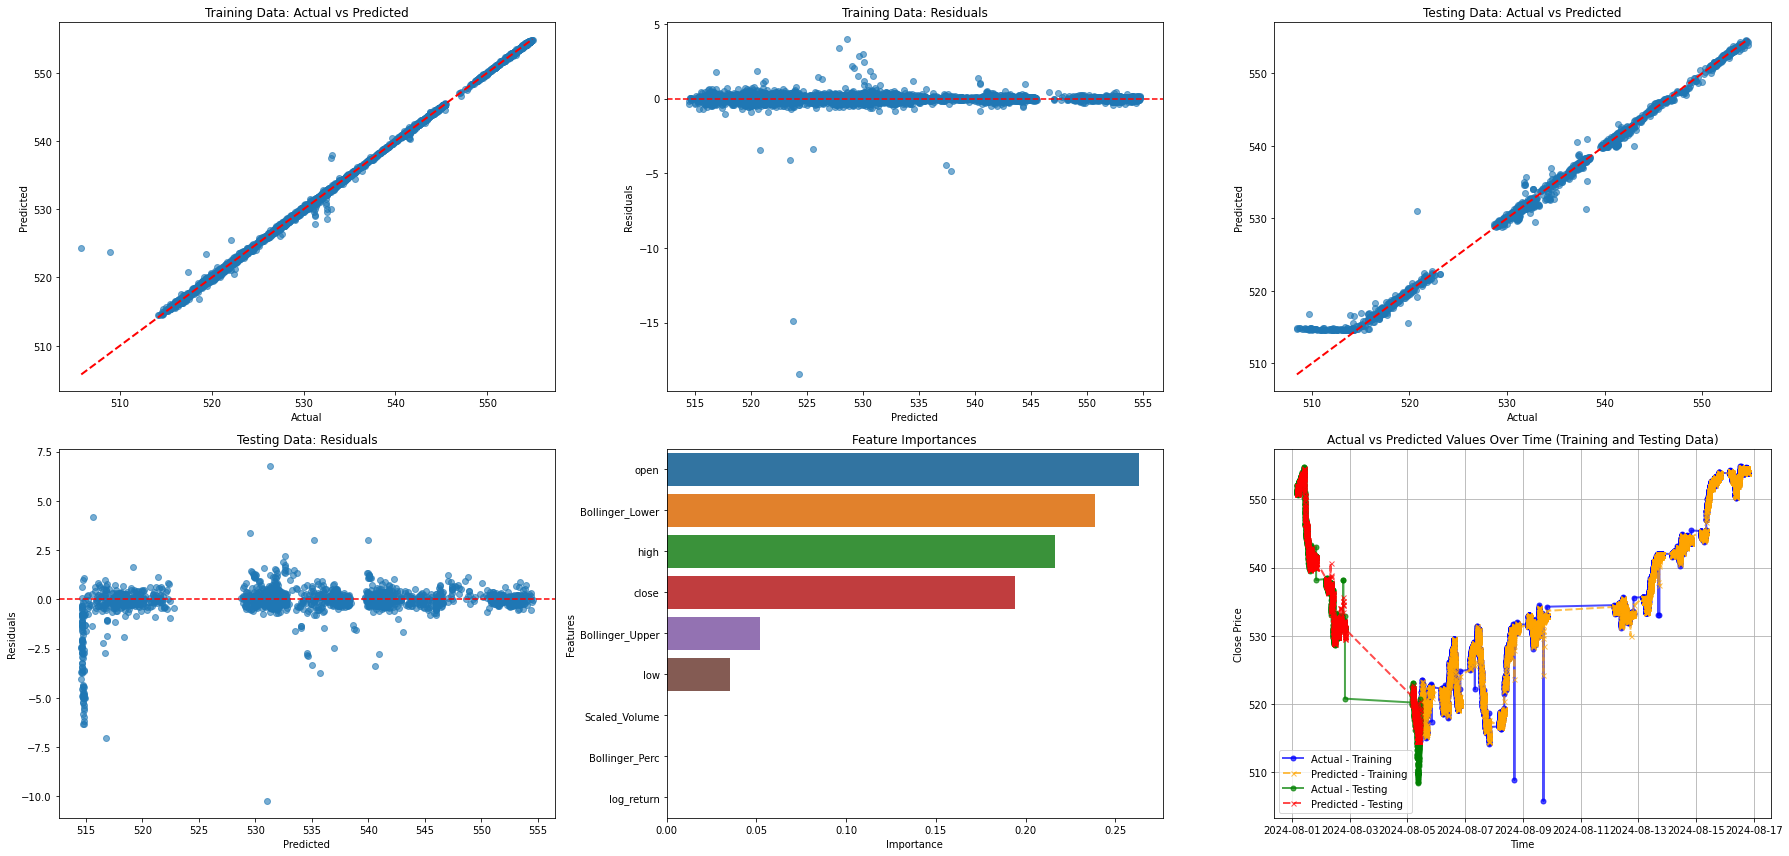

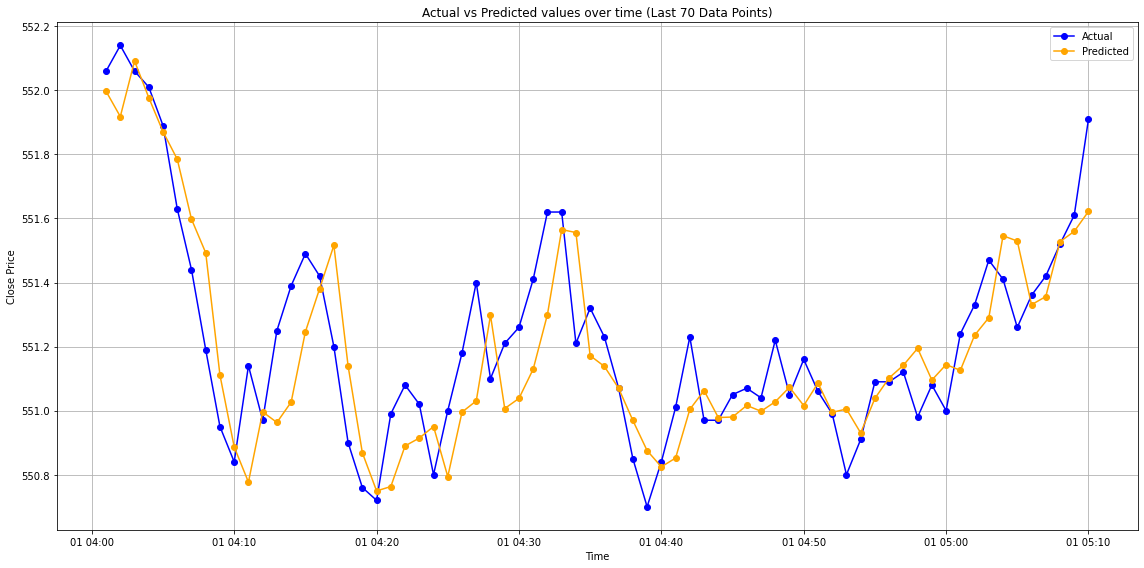

In [41]:
# Feature Engineering
data['SMA_20'] = data['close'].rolling(window=20).mean()
data['STD_20'] = data['close'].rolling(window=20).std()
data['Bollinger_Upper'] = data['SMA_20'] + (data['STD_20'] * 2)
data['Bollinger_Lower'] = data['SMA_20'] - (data['STD_20'] * 2)

# Optional: Distance from Bollinger Bands
data['Bollinger_Perc'] = (data['close'] - data['Bollinger_Lower']) / (data['Bollinger_Upper'] - data['Bollinger_Lower'])

# Drop NaN values resulting from the Bollinger Bands calculations
data.dropna(inplace=True)

# Define the features and target variable, now including Bollinger Bands-related features
features_bollinger = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume', 'Bollinger_Upper', 'Bollinger_Lower', 'Bollinger_Perc']
X = data[features_bollinger]
y = data['close_t+1']  # Target variable, already defined earlier

# Align features with the target
X = X[:-1]
y = y[:-1]

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model on the training data using the best parameters from hyperparameter tuning
best_rfr_model.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = best_rfr_model.predict(X_train)
y_test_pred = best_rfr_model.predict(X_test)

# Calculate metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training Data - RMSE: {train_rmse}, MAE: {train_mae}, R²: {train_r2}")
print(f"Testing Data - RMSE: {test_rmse}, MAE: {test_mae}, R²: {test_r2}")

# Perform cross-validation for the model with Bollinger Bands
cv_mse_bollinger = cross_val_score(best_rfr_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_bollinger = -cv_mse_bollinger  # Convert to positive MSE

# Ensure cv_mse_base is defined for statistical comparison
if 'cv_mse_base' not in globals():
    # Assuming the base model was trained using the same features minus Bollinger Bands-related features
    features_base = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume']
    X_base = data[features_base]
    y_base = data['close_t+1'][:-1]  # Align the target with the features
    
    # Align X_base with y_base by dropping the last row of X_base
    X_base = X_base[:-1]  # Drop the last row to match the length of y_base

    # Perform cross-validation for the base model
    cv_mse_base = cross_val_score(best_rfr_model, X_base, y_base, cv=5, scoring='neg_mean_squared_error')
    cv_mse_base = -cv_mse_base  # Convert to positive MSE

# Perform statistical testing between the base model and Bollinger Bands model
stat_test_result = perform_stat_test(cv_mse_base, cv_mse_bollinger, 'Bollinger Bands')

# Store the result for later analysis
if 't_test_results' not in globals():
    t_test_results = []
t_test_results.append(stat_test_result)

# Feature Importance
feature_importances = best_rfr_model.feature_importances_

# Plotting the results using the previously defined plot function
plot_rfr_results(
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
    feature_importances=feature_importances,
    feature_names=features_bollinger,
    data=data,
    last_n=70  # Customize as needed
)

# Save the results and cross-validation MSE to CSV for future reference
results_df = pd.DataFrame({
    'Model': ['Bollinger Bands Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2]
})
results_df.to_csv('bollinger_bands_model_performance_metrics.csv', index=False)

cv_results_df = pd.DataFrame({
    'Fold': range(1, len(cv_mse_bollinger) + 1),
    'MSE': cv_mse_bollinger
})
cv_results_df.to_csv('bollinger_bands_model_cross_validation_results.csv', index=False)


## Stochastic Oscillator

Training Data - RMSE: 0.3420456834573068, MAE: 0.11989435775852045, R²: 0.9990923410241056
Testing Data - RMSE: 0.9552740791016575, MAE: 0.4052979421057608, R²: 0.9927214962552994
Stochastic Oscillator t-statistic: -2.1235377823441746, p-value: 0.10093920860034218


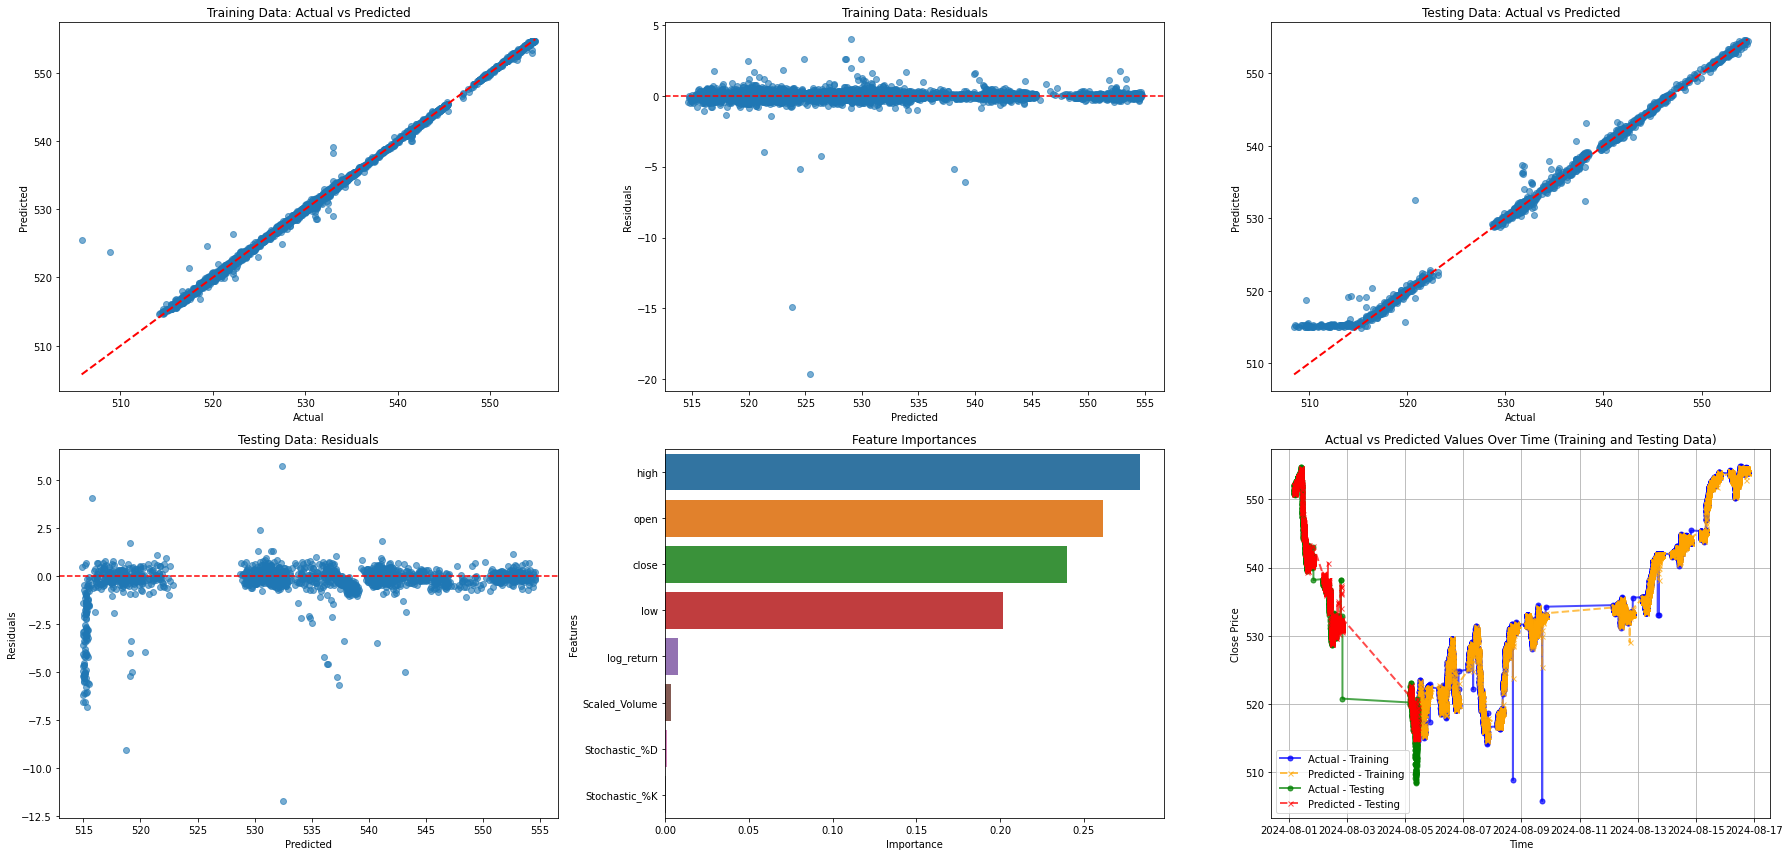

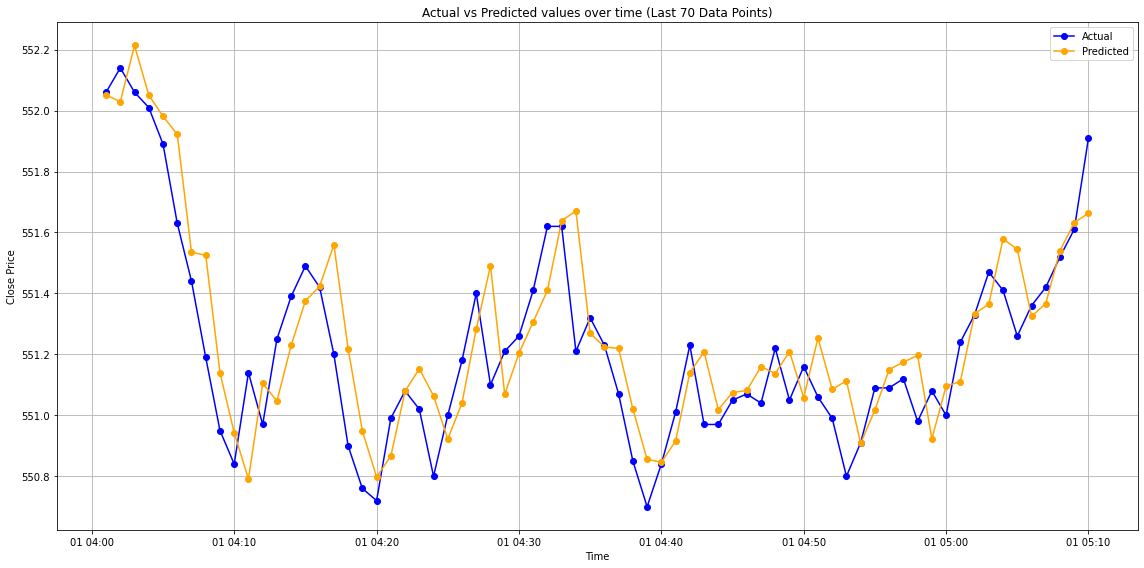

In [42]:
# Feature Engineering
data['Lowest_Low_14'] = data['low'].rolling(window=14).min()
data['Highest_High_14'] = data['high'].rolling(window=14).max()
data['Stochastic_%K'] = 100 * ((data['close'] - data['Lowest_Low_14']) / (data['Highest_High_14'] - data['Lowest_Low_14']))
data['Stochastic_%D'] = data['Stochastic_%K'].rolling(window=3).mean()

# Drop NaN values resulting from the Stochastic Oscillator calculation
data.dropna(inplace=True)

# Define the features and target variable, now including the Stochastic Oscillator
features_stochastic = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume', 'Stochastic_%K', 'Stochastic_%D']
X = data[features_stochastic]
y = data['close_t+1']  # Target variable, already defined earlier

# Align features with the target
X = X[:-1]
y = y[:-1]

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model on the training data using the best parameters from hyperparameter tuning
best_rfr_model.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = best_rfr_model.predict(X_train)
y_test_pred = best_rfr_model.predict(X_test)

# Calculate metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training Data - RMSE: {train_rmse}, MAE: {train_mae}, R²: {train_r2}")
print(f"Testing Data - RMSE: {test_rmse}, MAE: {test_mae}, R²: {test_r2}")

# Perform cross-validation for the model with Stochastic Oscillator
cv_mse_stochastic = cross_val_score(best_rfr_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_stochastic = -cv_mse_stochastic  # Convert to positive MSE

# Ensure cv_mse_base is defined for statistical comparison
if 'cv_mse_base' not in globals():
    # Assuming the base model was trained using the same features minus the Stochastic Oscillator-related features
    features_base = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume']
    X_base = data[features_base]
    y_base = data['close_t+1'][:-1]  # Align the target with the features
    
    # Align X_base with y_base by dropping the last row of X_base
    X_base = X_base[:-1]  # Drop the last row to match the length of y_base

    # Perform cross-validation for the base model
    cv_mse_base = cross_val_score(best_rfr_model, X_base, y_base, cv=5, scoring='neg_mean_squared_error')
    cv_mse_base = -cv_mse_base  # Convert to positive MSE

# Perform statistical testing between the base model and Stochastic Oscillator model
stat_test_result = perform_stat_test(cv_mse_base, cv_mse_stochastic, 'Stochastic Oscillator')

# Store the result for later analysis
if 't_test_results' not in globals():
    t_test_results = []
t_test_results.append(stat_test_result)

# Feature Importance
feature_importances = best_rfr_model.feature_importances_

# Plotting the results using the previously defined plot function
plot_rfr_results(
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
    feature_importances=feature_importances,
    feature_names=features_stochastic,
    data=data,
    last_n=70  # Customize as needed
)

# Save the results and cross-validation MSE to CSV for future reference
results_df = pd.DataFrame({
    'Model': ['Stochastic Oscillator Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2]
})
results_df.to_csv('stochastic_oscillator_model_performance_metrics.csv', index=False)

cv_results_df = pd.DataFrame({
    'Fold': range(1, len(cv_mse_stochastic) + 1),
    'MSE': cv_mse_stochastic
})
cv_results_df.to_csv('stochastic_oscillator_model_cross_validation_results.csv', index=False)


## Fibbonnacci Retracement

Training Data - RMSE: 0.33520661765618615, MAE: 0.11359959456121128, R²: 0.9991253633582431
Testing Data - RMSE: 1.0455734582413458, MAE: 0.42716918651509045, R²: 0.9912517108329307
Fibonacci Retracement t-statistic: -2.1033753326373783, p-value: 0.10325917120761782


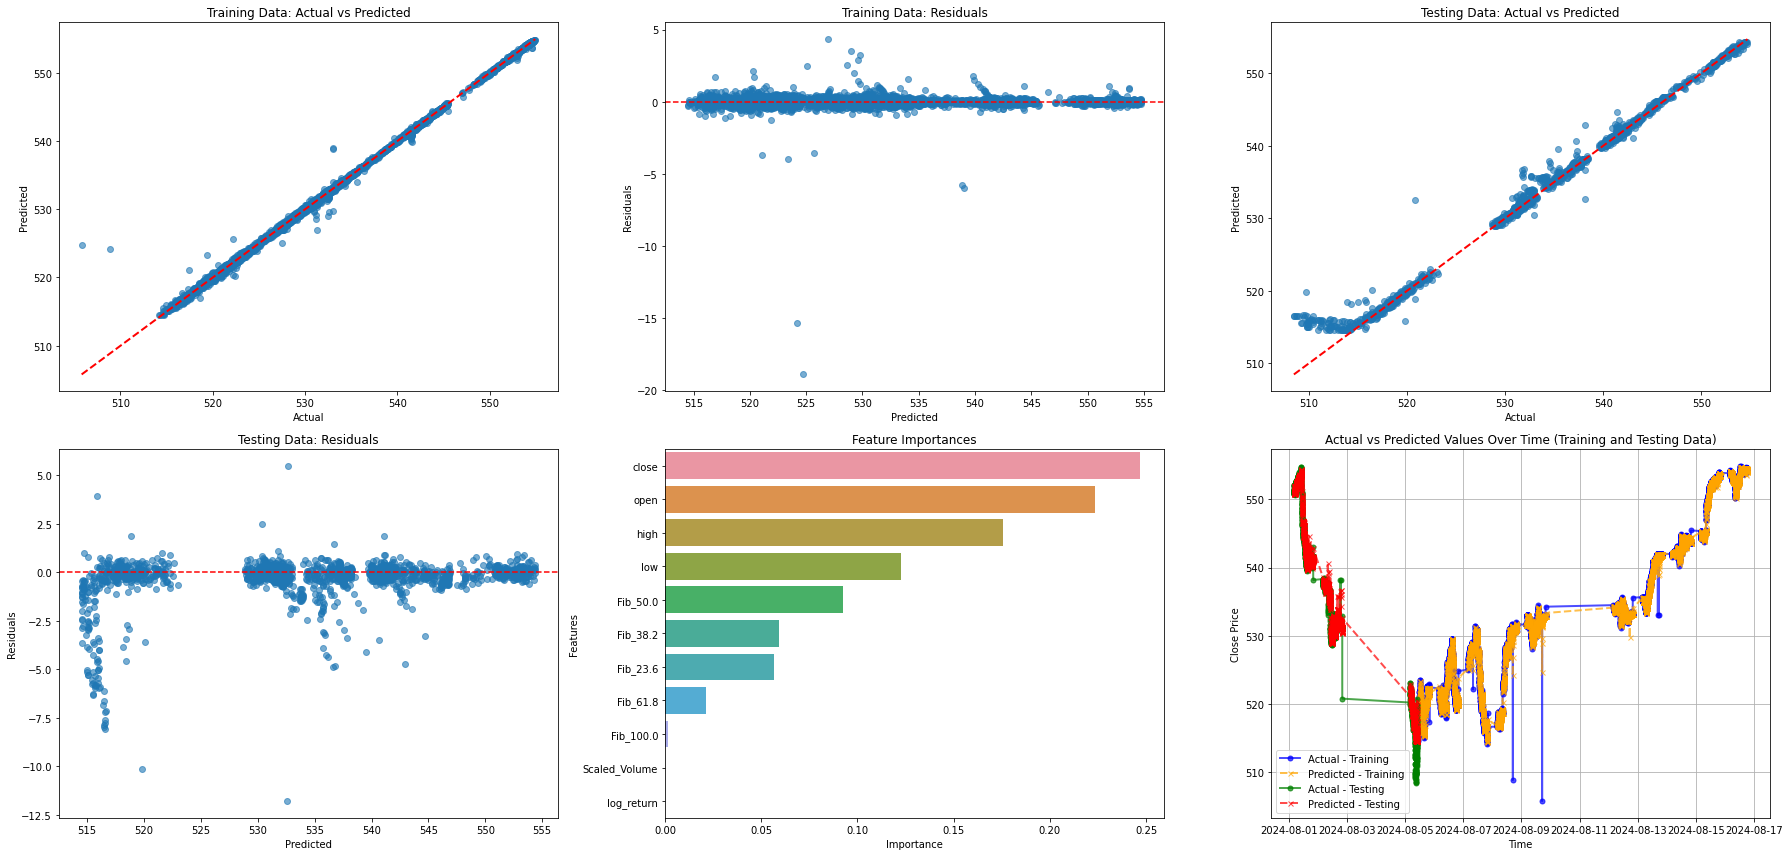

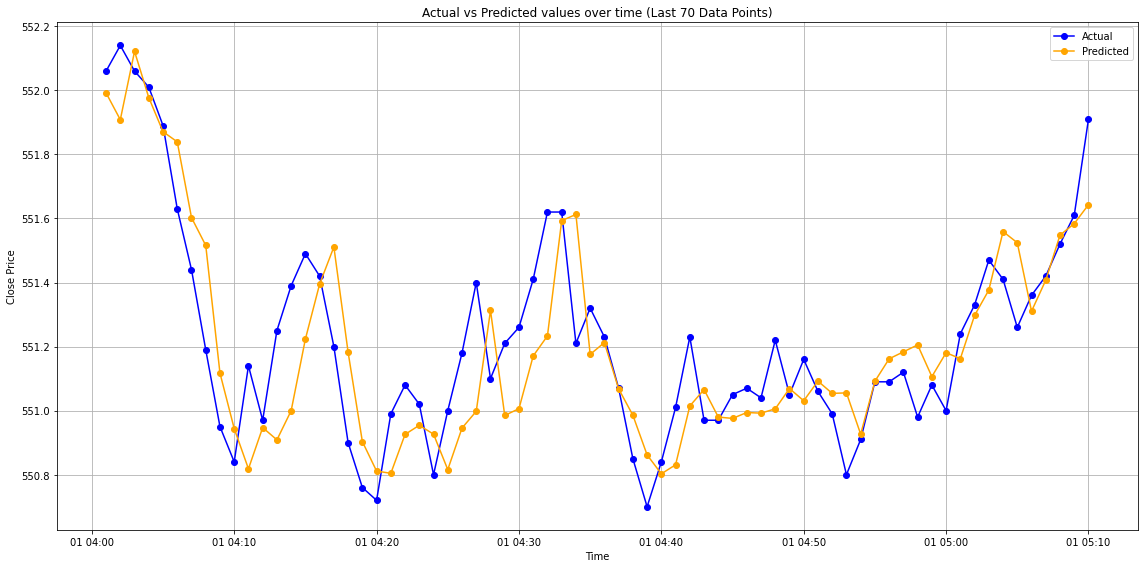

In [43]:
# Feature Engineering
lookback_period = 20  # You can adjust this period based on your needs

data['Swing_High'] = data['high'].rolling(window=lookback_period).max()
data['Swing_Low'] = data['low'].rolling(window=lookback_period).min()

# Fibonacci levels
data['Fib_23.6'] = data['Swing_High'] - (data['Swing_High'] - data['Swing_Low']) * 0.236
data['Fib_38.2'] = data['Swing_High'] - (data['Swing_High'] - data['Swing_Low']) * 0.382
data['Fib_50.0'] = data['Swing_High'] - (data['Swing_High'] - data['Swing_Low']) * 0.5
data['Fib_61.8'] = data['Swing_High'] - (data['Swing_High'] - data['Swing_Low']) * 0.618
data['Fib_100.0'] = data['Swing_Low']  # This is the same as Swing_Low

# Drop NaN values resulting from rolling operations
data.dropna(inplace=True)

# Define the features and target variable, now including Fibonacci Retracement levels
features_fibonacci = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume', 
                      'Fib_23.6', 'Fib_38.2', 'Fib_50.0', 'Fib_61.8', 'Fib_100.0']
X = data[features_fibonacci]
y = data['close_t+1']  # Target variable, already defined earlier

# Align features with the target
X = X[:-1]
y = y[:-1]

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model on the training data using the best parameters from hyperparameter tuning
best_rfr_model.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = best_rfr_model.predict(X_train)
y_test_pred = best_rfr_model.predict(X_test)

# Calculate metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training Data - RMSE: {train_rmse}, MAE: {train_mae}, R²: {train_r2}")
print(f"Testing Data - RMSE: {test_rmse}, MAE: {test_mae}, R²: {test_r2}")

# Perform cross-validation for the model with Fibonacci Retracement
cv_mse_fibonacci = cross_val_score(best_rfr_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_fibonacci = -cv_mse_fibonacci  # Convert to positive MSE

# Ensure cv_mse_base is defined for statistical comparison
if 'cv_mse_base' not in globals():
    # Assuming the base model was trained using the same features minus Fibonacci Retracement-related features
    features_base = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume']
    X_base = data[features_base]
    y_base = data['close_t+1'][:-1]  # Align the target with the features
    
    # Align X_base with y_base by dropping the last row of X_base
    X_base = X_base[:-1]  # Drop the last row to match the length of y_base

    # Perform cross-validation for the base model
    cv_mse_base = cross_val_score(best_rfr_model, X_base, y_base, cv=5, scoring='neg_mean_squared_error')
    cv_mse_base = -cv_mse_base  # Convert to positive MSE

# Perform statistical testing between the base model and Fibonacci Retracement model
stat_test_result = perform_stat_test(cv_mse_base, cv_mse_fibonacci, 'Fibonacci Retracement')

# Store the result for later analysis
if 't_test_results' not in globals():
    t_test_results = []
t_test_results.append(stat_test_result)

# Feature Importance
feature_importances = best_rfr_model.feature_importances_

# Plotting the results using the previously defined plot function
plot_rfr_results(
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
    feature_importances=feature_importances,
    feature_names=features_fibonacci,
    data=data,
    last_n=70  # Customize as needed
)

# Save the results and cross-validation MSE to CSV for future reference
results_df = pd.DataFrame({
    'Model': ['Fibonacci Retracement Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2]
})
results_df.to_csv('fibonacci_retracement_model_performance_metrics.csv', index=False)

cv_results_df = pd.DataFrame({
    'Fold': range(1, len(cv_mse_fibonacci) + 1),
    'MSE': cv_mse_fibonacci
})
cv_results_df.to_csv('fibonacci_retracement_model_cross_validation_results.csv', index=False)


## ADX

Training Data - RMSE: 0.33359387384094474, MAE: 0.11306133779813973, R²: 0.9991335780103449
Testing Data - RMSE: 0.8875266155495672, MAE: 0.3813231969987641, R²: 0.9936965719363807
ADX t-statistic: -2.3503582646487433, p-value: 0.0784846245409925


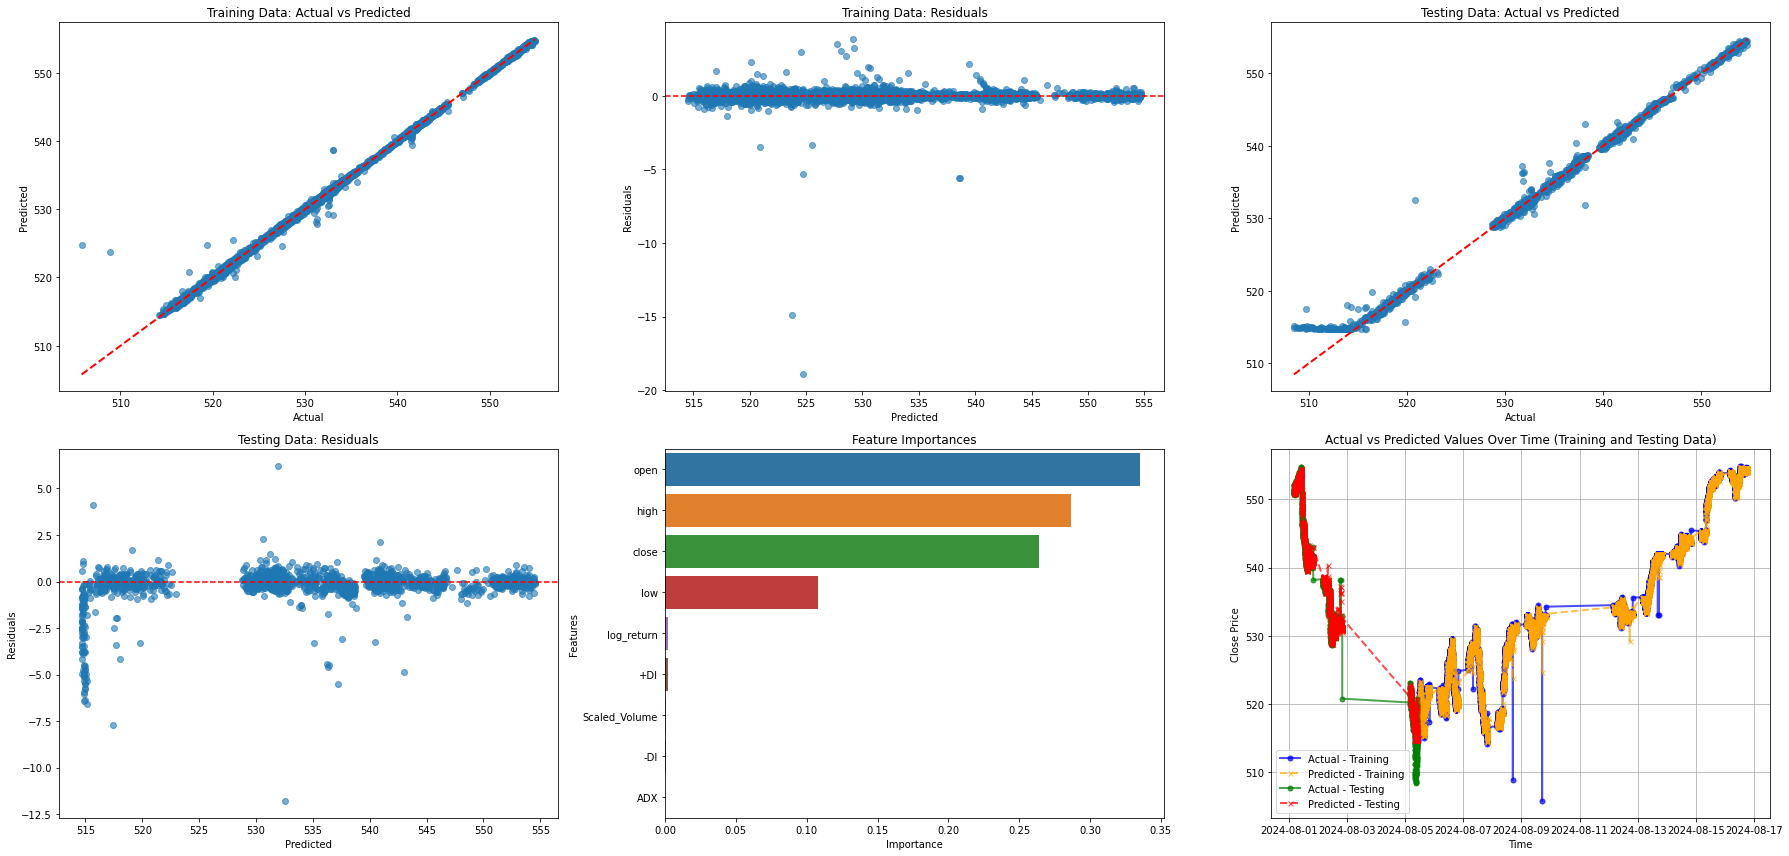

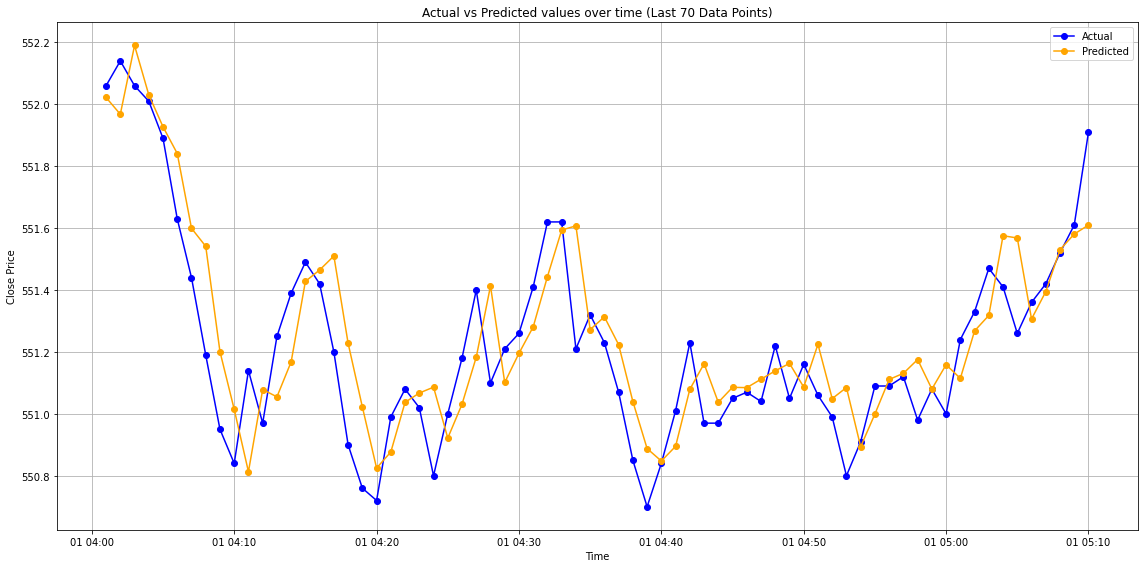

In [44]:
# Feature Engineering for ADX
data['High-Low'] = data['high'] - data['low']
data['High-Close'] = np.abs(data['high'] - data['close'].shift(1))
data['Low-Close'] = np.abs(data['low'] - data['close'].shift(1))
data['TR'] = data[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)

data['+DM'] = np.where((data['high'] - data['high'].shift(1)) > (data['low'].shift(1) - data['low']), 
                       data['high'] - data['high'].shift(1), 0)
data['-DM'] = np.where((data['low'].shift(1) - data['low']) > (data['high'] - data['high'].shift(1)), 
                       data['low'].shift(1) - data['low'], 0)

data['+DI'] = 100 * (data['+DM'].ewm(alpha=1/14, adjust=False).mean() / data['TR'].ewm(alpha=1/14, adjust=False).mean())
data['-DI'] = 100 * (data['-DM'].ewm(alpha=1/14, adjust=False).mean() / data['TR'].ewm(alpha=1/14, adjust=False).mean())

data['DX'] = 100 * np.abs(data['+DI'] - data['-DI']) / (data['+DI'] + data['-DI'])
data['ADX'] = data['DX'].ewm(alpha=1/14, adjust=False).mean()

# Drop NaN values resulting from rolling operations
data.dropna(inplace=True)

# Define the features and target variable, now including ADX
features_adx = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume', '+DI', '-DI', 'ADX']
X = data[features_adx]
y = data['close_t+1']  # Target variable, already defined earlier

# Align features with the target
X = X[:-1]
y = y[:-1]

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model on the training data using the best parameters from hyperparameter tuning
best_rfr_model.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = best_rfr_model.predict(X_train)
y_test_pred = best_rfr_model.predict(X_test)

# Calculate metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training Data - RMSE: {train_rmse}, MAE: {train_mae}, R²: {train_r2}")
print(f"Testing Data - RMSE: {test_rmse}, MAE: {test_mae}, R²: {test_r2}")

# Perform cross-validation for the model with ADX
cv_mse_adx = cross_val_score(best_rfr_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_adx = -cv_mse_adx  # Convert to positive MSE

# Ensure cv_mse_base is defined for statistical comparison
if 'cv_mse_base' not in globals():
    # Assuming the base model was trained using the same features minus ADX-related features
    features_base = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume']
    X_base = data[features_base]
    y_base = data['close_t+1'][:-1]  # Align the target with the features
    
    # Align X_base with y_base by dropping the last row of X_base
    X_base = X_base[:-1]  # Drop the last row to match the length of y_base

    # Perform cross-validation for the base model
    cv_mse_base = cross_val_score(best_rfr_model, X_base, y_base, cv=5, scoring='neg_mean_squared_error')
    cv_mse_base = -cv_mse_base  # Convert to positive MSE

# Perform statistical testing between the base model and ADX model
stat_test_result = perform_stat_test(cv_mse_base, cv_mse_adx, 'ADX')

# Store the result for later analysis
if 't_test_results' not in globals():
    t_test_results = []
t_test_results.append(stat_test_result)

# Feature Importance
feature_importances = best_rfr_model.feature_importances_

# Plotting the results using the previously defined plot function
plot_rfr_results(
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
    feature_importances=feature_importances,
    feature_names=features_adx,
    data=data,
    last_n=70  # Customize as needed
)

# Save the results and cross-validation MSE to CSV for future reference
results_df = pd.DataFrame({
    'Model': ['ADX Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2]
})
results_df.to_csv('adx_model_performance_metrics.csv', index=False)

cv_results_df = pd.DataFrame({
    'Fold': range(1, len(cv_mse_adx) + 1),
    'MSE': cv_mse_adx
})
cv_results_df.to_csv('adx_model_cross_validation_results.csv', index=False)


## OBV

Training Data - RMSE: 0.3393867409492204, MAE: 0.11857291627580292, R²: 0.9991032258608168
Testing Data - RMSE: 1.8733081900534263, MAE: 1.377310548483155, R²: 0.9719177117313065
OBV t-statistic: -1.5110839824362265, p-value: 0.20529404836152487


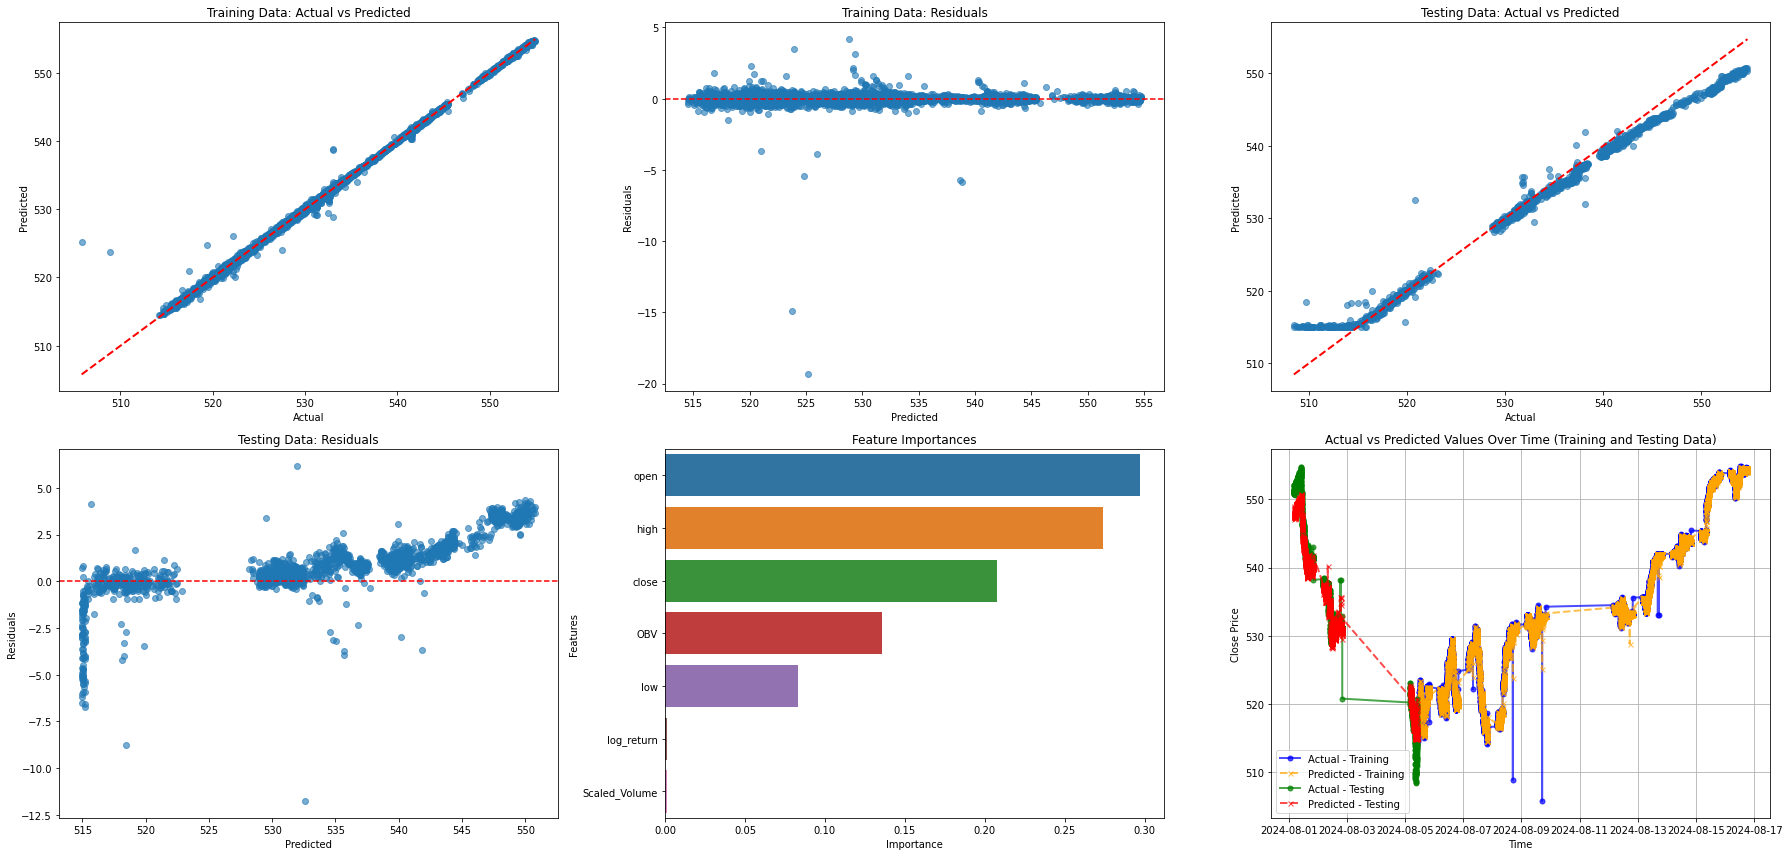

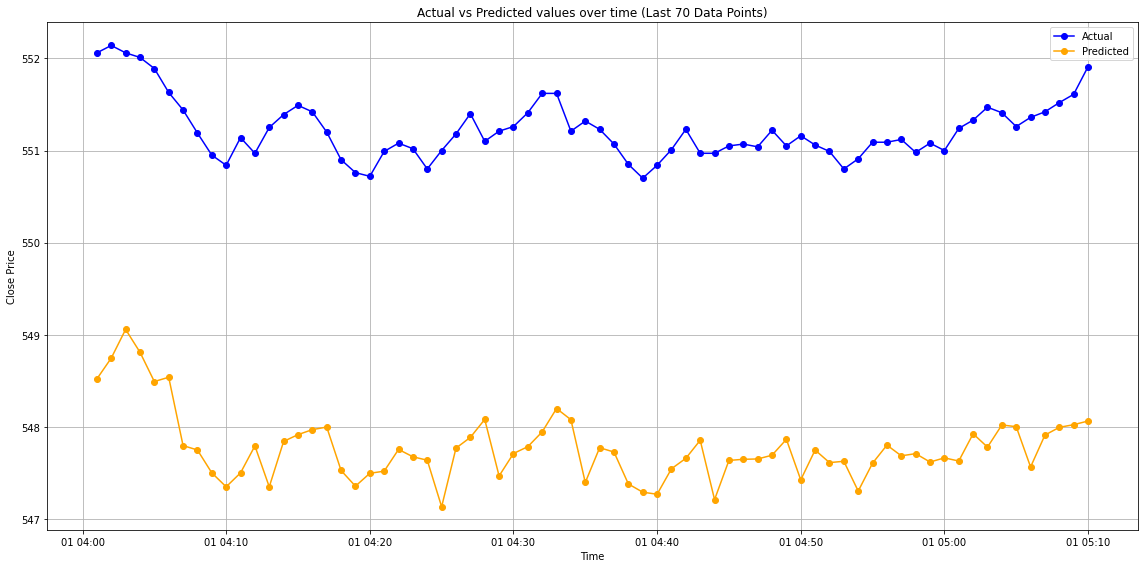

In [45]:
# Feature Engineering for OBV
data['OBV'] = np.where(data['close'] > data['close'].shift(1), data['volume'], 
                       np.where(data['close'] < data['close'].shift(1), -data['volume'], 0)).cumsum()

# Scaling features including OBV and closing price
scaler = MinMaxScaler()
data[['Scaled_Volume', 'OBV', 'close']] = scaler.fit_transform(data[['volume', 'OBV', 'close']])

# Drop NaN values resulting from shifting operations
data.dropna(inplace=True)

# Define the features and target variable, now including OBV
features_obv = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume', 'OBV']
X = data[features_obv]
y = data['close_t+1']  # Target variable, already defined earlier

# Align features with the target
X = X[:-1]
y = y[:-1]

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model on the training data using the best parameters from hyperparameter tuning
best_rfr_model.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = best_rfr_model.predict(X_train)
y_test_pred = best_rfr_model.predict(X_test)

# Calculate metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training Data - RMSE: {train_rmse}, MAE: {train_mae}, R²: {train_r2}")
print(f"Testing Data - RMSE: {test_rmse}, MAE: {test_mae}, R²: {test_r2}")

# Perform cross-validation for the model with OBV
cv_mse_obv = cross_val_score(best_rfr_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_obv = -cv_mse_obv  # Convert to positive MSE

# Ensure cv_mse_base is defined for statistical comparison
if 'cv_mse_base' not in globals():
    # Assuming the base model was trained using the same features minus OBV
    features_base = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume']
    X_base = data[features_base]
    y_base = data['close_t+1'][:-1]  # Align the target with the features
    
    # Align X_base with y_base by dropping the last row of X_base
    X_base = X_base[:-1]  # Drop the last row to match the length of y_base

    # Perform cross-validation for the base model
    cv_mse_base = cross_val_score(best_rfr_model, X_base, y_base, cv=5, scoring='neg_mean_squared_error')
    cv_mse_base = -cv_mse_base  # Convert to positive MSE

# Perform statistical testing between the base model and OBV model
stat_test_result = perform_stat_test(cv_mse_base, cv_mse_obv, 'OBV')

# Store the result for later analysis
if 't_test_results' not in globals():
    t_test_results = []
t_test_results.append(stat_test_result)

# Feature Importance
feature_importances = best_rfr_model.feature_importances_

# Plotting the results using the previously defined plot function
plot_rfr_results(
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
    feature_importances=feature_importances,
    feature_names=features_obv,
    data=data,
    last_n=70  # Customize as needed
)

# Save the results and cross-validation MSE to CSV for future reference
results_df = pd.DataFrame({
    'Model': ['OBV Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2]
})
results_df.to_csv('obv_model_performance_metrics.csv', index=False)

cv_results_df = pd.DataFrame({
    'Fold': range(1, len(cv_mse_obv) + 1),
    'MSE': cv_mse_obv
})
cv_results_df.to_csv('obv_model_cross_validation_results.csv', index=False)


## CCI

Training Data - RMSE: 0.3327472730003649, MAE: 0.11447299815399972, R²: 0.9991347861115377
Testing Data - RMSE: 0.9091681106330741, MAE: 0.37752466452593125, R²: 0.9933677421055203
CCI t-statistic: -1.3894653327407798, p-value: 0.23703424562225714


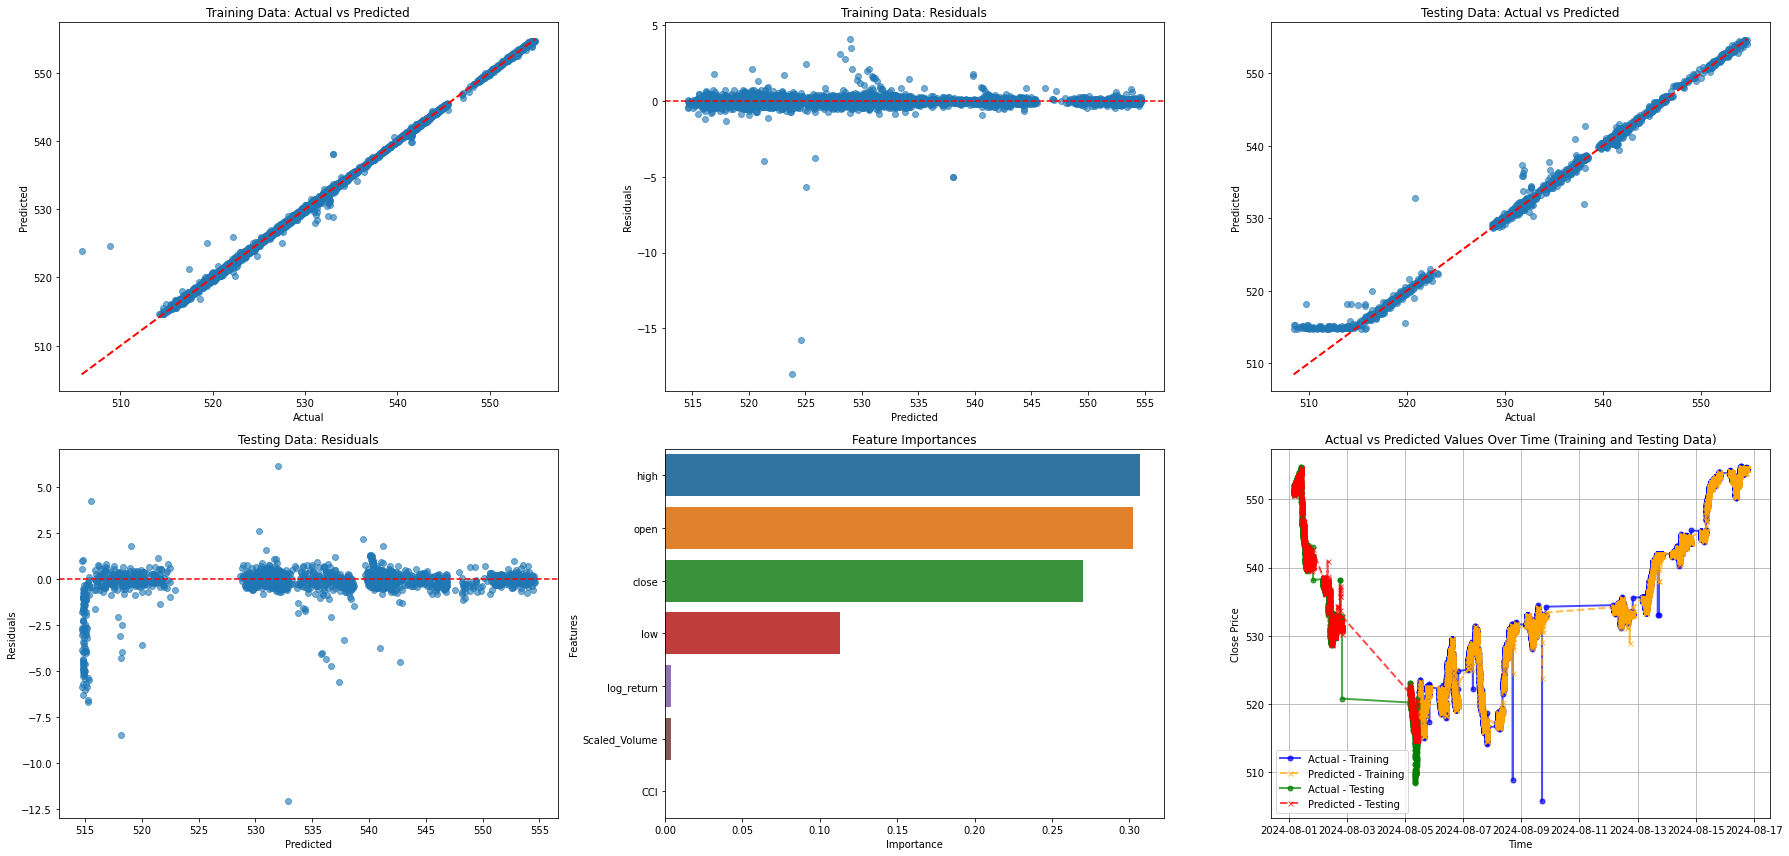

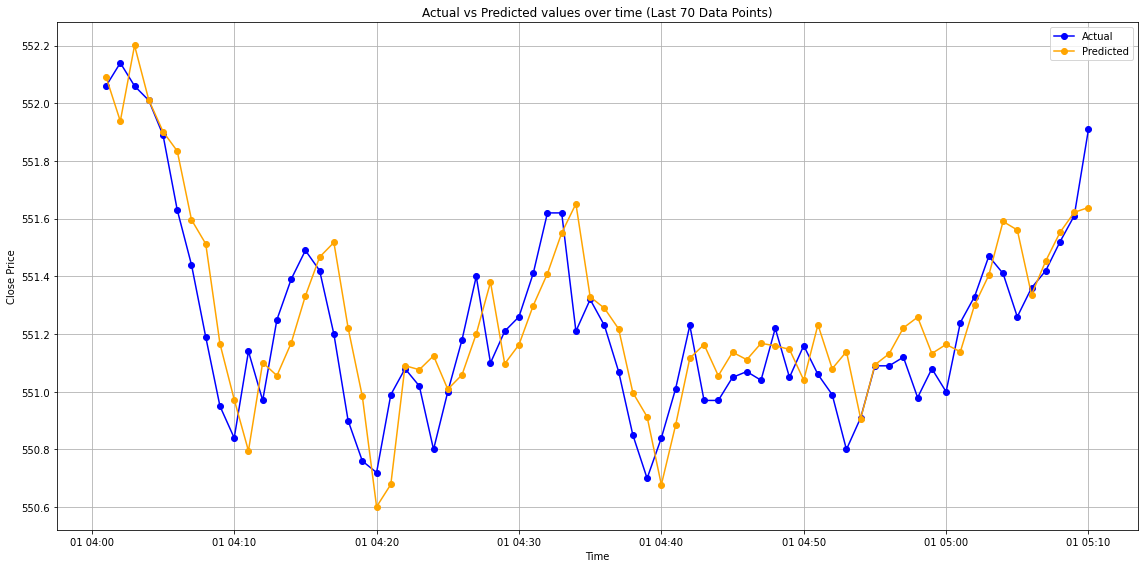

In [46]:
# Feature Engineering for CCI
data['Typical_Price'] = (data['high'] + data['low'] + data['close']) / 3
data['SMA_Typical_Price'] = data['Typical_Price'].rolling(window=20).mean()
data['Mean_Deviation'] = data['Typical_Price'].rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))

# Calculate CCI
data['CCI'] = (data['Typical_Price'] - data['SMA_Typical_Price']) / (0.015 * data['Mean_Deviation'])

# Drop NaN values resulting from rolling operations
data.dropna(inplace=True)

# Define the features and target variable, now including CCI
features_cci = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume', 'CCI']
X = data[features_cci]
y = data['close_t+1']  # Target variable, already defined earlier

# Align features with the target
X = X[:-1]
y = y[:-1]

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model on the training data using the best parameters from hyperparameter tuning
best_rfr_model.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = best_rfr_model.predict(X_train)
y_test_pred = best_rfr_model.predict(X_test)

# Calculate metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training Data - RMSE: {train_rmse}, MAE: {train_mae}, R²: {train_r2}")
print(f"Testing Data - RMSE: {test_rmse}, MAE: {test_mae}, R²: {test_r2}")

# Perform cross-validation for the model with CCI
cv_mse_cci = cross_val_score(best_rfr_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_cci = -cv_mse_cci  # Convert to positive MSE

# Ensure cv_mse_base is defined for statistical comparison
if 'cv_mse_base' not in globals():
    # Assuming the base model was trained using the same features minus CCI
    features_base = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume']
    X_base = data[features_base]
    y_base = data['close_t+1'][:-1]  # Align the target with the features
    
    # Align X_base with y_base by dropping the last row of X_base
    X_base = X_base[:-1]  # Drop the last row to match the length of y_base

    # Perform cross-validation for the base model
    cv_mse_base = cross_val_score(best_rfr_model, X_base, y_base, cv=5, scoring='neg_mean_squared_error')
    cv_mse_base = -cv_mse_base  # Convert to positive MSE

# Perform statistical testing between the base model and CCI model
stat_test_result = perform_stat_test(cv_mse_base, cv_mse_cci, 'CCI')

# Store the result for later analysis
if 't_test_results' not in globals():
    t_test_results = []
t_test_results.append(stat_test_result)

# Feature Importance
feature_importances = best_rfr_model.feature_importances_

# Plotting the results using the previously defined plot function
plot_rfr_results(
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
    feature_importances=feature_importances,
    feature_names=features_cci,
    data=data,
    last_n=70  # Customize as needed
)

# Save the results and cross-validation MSE to CSV for future reference
results_df = pd.DataFrame({
    'Model': ['CCI Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2]
})
results_df.to_csv('cci_model_performance_metrics.csv', index=False)

cv_results_df = pd.DataFrame({
    'Fold': range(1, len(cv_mse_cci) + 1),
    'MSE': cv_mse_cci
})
cv_results_df.to_csv('cci_model_cross_validation_results.csv', index=False)


## Ichimoku Cloud Indicator 

Training Data - RMSE: 0.32662733869200417, MAE: 0.10928796147894218, R²: 0.9991503781851214
Testing Data - RMSE: 0.9702396196585578, MAE: 0.4173235204436166, R²: 0.9924053856320811
Ichimoku Cloud t-statistic: -2.1535875224841328, p-value: 0.09758809662116012


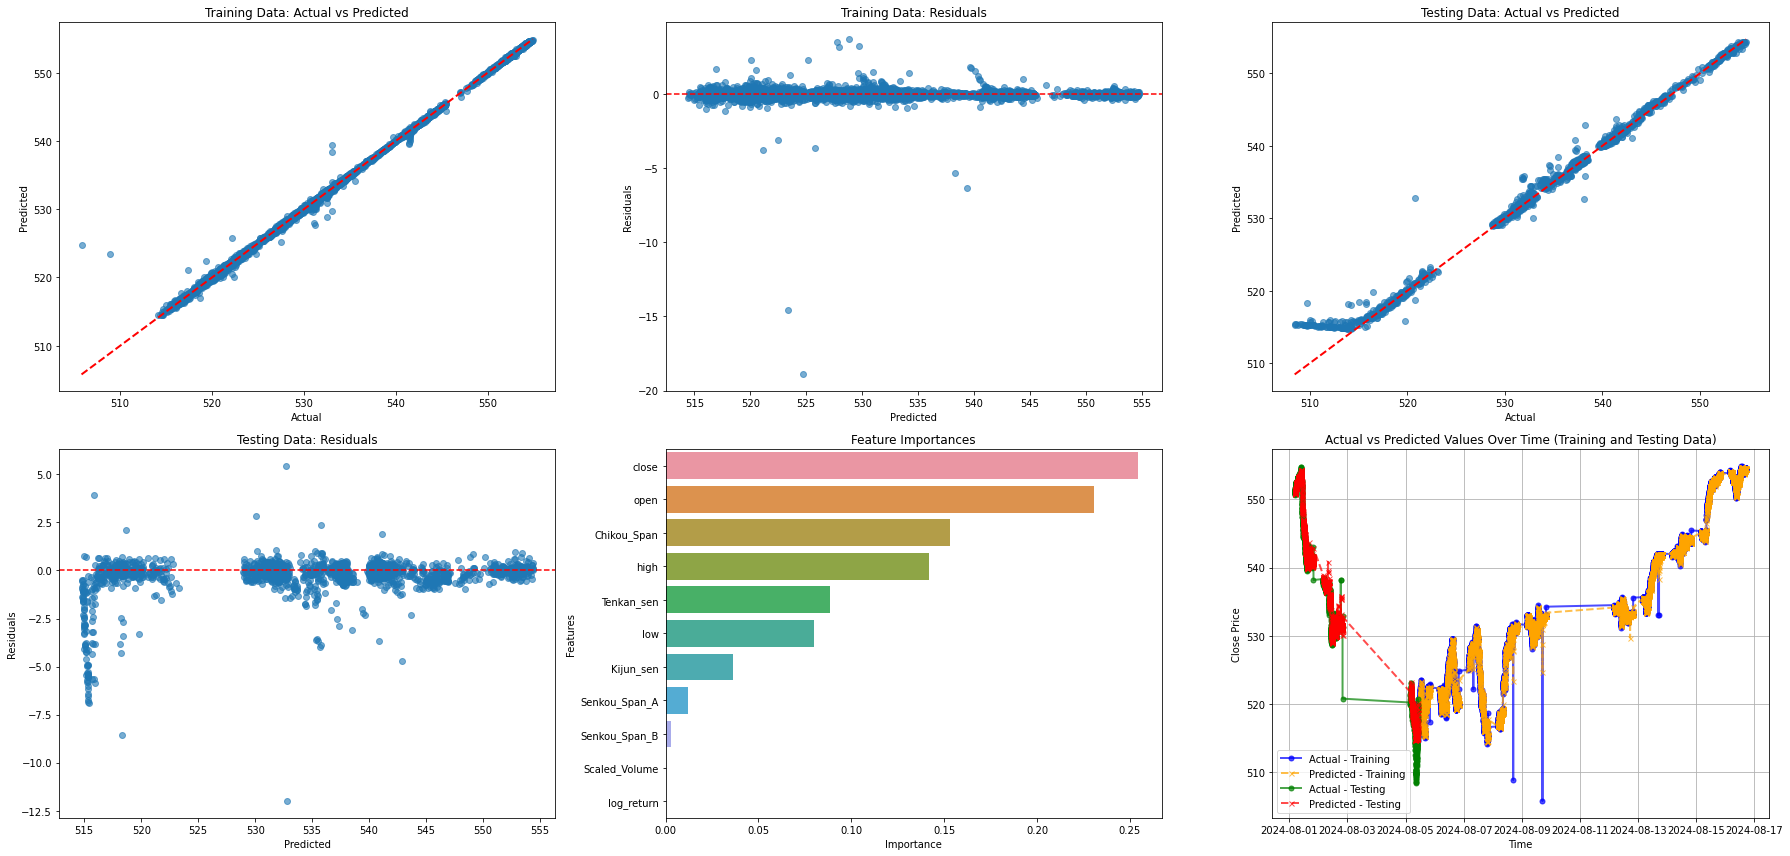

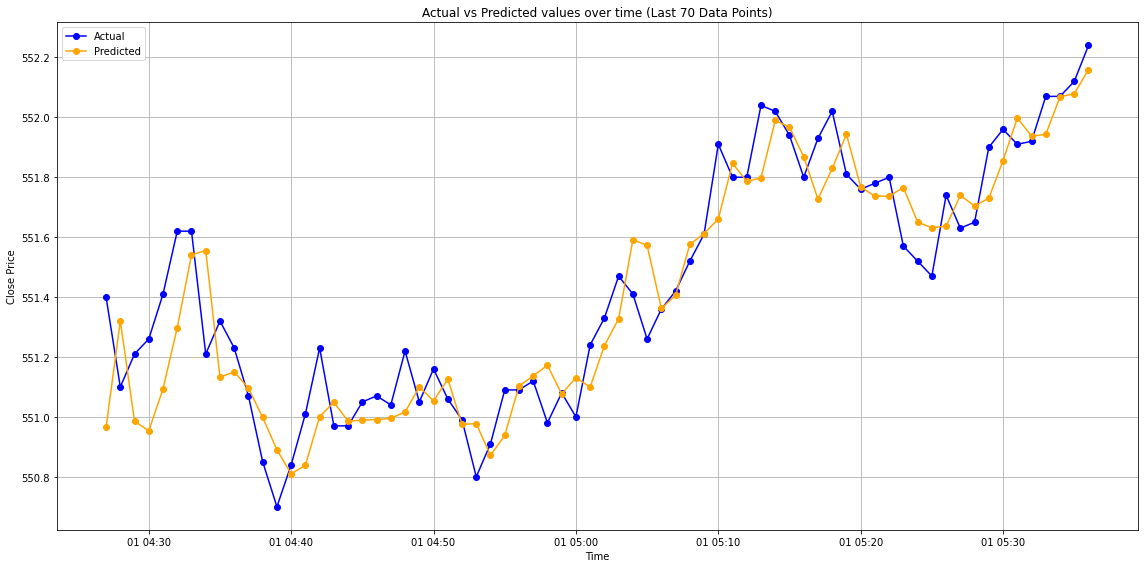

In [47]:
# Feature Engineering for Ichimoku Cloud
high_9 = data['high'].rolling(window=9).max()
low_9 = data['low'].rolling(window=9).min()
high_26 = data['high'].rolling(window=26).max()
low_26 = data['low'].rolling(window=26).min()
high_52 = data['high'].rolling(window=52).max()
low_52 = data['low'].rolling(window=52).min()

data['Tenkan_sen'] = (high_9 + low_9) / 2  # Conversion Line
data['Kijun_sen'] = (high_26 + low_26) / 2  # Base Line
data['Senkou_Span_A'] = ((data['Tenkan_sen'] + data['Kijun_sen']) / 2).shift(26)  # Leading Span A
data['Senkou_Span_B'] = ((high_52 + low_52) / 2).shift(26)  # Leading Span B
data['Chikou_Span'] = data['close'].shift(-26)  # Lagging Span

# Drop NaN values resulting from rolling operations
data.dropna(inplace=True)

# Define the features and target variable, now including Ichimoku Cloud components
features_ichimoku = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume',
                     'Tenkan_sen', 'Kijun_sen', 'Senkou_Span_A', 'Senkou_Span_B', 'Chikou_Span']
X = data[features_ichimoku]
y = data['close_t+1']  # Target variable, already defined earlier

# Align features with the target
X = X[:-1]
y = y[:-1]

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model on the training data using the best parameters from hyperparameter tuning
best_rfr_model.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = best_rfr_model.predict(X_train)
y_test_pred = best_rfr_model.predict(X_test)

# Calculate metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the evaluation metrics
print(f"Training Data - RMSE: {train_rmse}, MAE: {train_mae}, R²: {train_r2}")
print(f"Testing Data - RMSE: {test_rmse}, MAE: {test_mae}, R²: {test_r2}")

# Perform cross-validation for the model with Ichimoku Cloud
cv_mse_ichimoku = cross_val_score(best_rfr_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_ichimoku = -cv_mse_ichimoku  # Convert to positive MSE

# Ensure cv_mse_base is defined for statistical comparison
if 'cv_mse_base' not in globals():
    # Assuming the base model was trained using the same features minus Ichimoku Cloud-related features
    features_base = ['open', 'high', 'low', 'close', 'log_return', 'Scaled_Volume']
    X_base = data[features_base]
    y_base = data['close_t+1'][:-1]  # Align the target with the features
    
    # Align X_base with y_base by dropping the last row of X_base
    X_base = X_base[:-1]  # Drop the last row to match the length of y_base

    # Perform cross-validation for the base model
    cv_mse_base = cross_val_score(best_rfr_model, X_base, y_base, cv=5, scoring='neg_mean_squared_error')
    cv_mse_base = -cv_mse_base  # Convert to positive MSE

# Perform statistical testing between the base model and Ichimoku Cloud model
stat_test_result = perform_stat_test(cv_mse_base, cv_mse_ichimoku, 'Ichimoku Cloud')

# Store the result for later analysis
if 't_test_results' not in globals():
    t_test_results = []
t_test_results.append(stat_test_result)

# Feature Importance
feature_importances = best_rfr_model.feature_importances_

# Plotting the results using the previously defined plot function
plot_rfr_results(
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
    feature_importances=feature_importances,
    feature_names=features_ichimoku,
    data=data,
    last_n=70  # Customize as needed
)

# Save the results and cross-validation MSE to CSV for future reference
results_df = pd.DataFrame({
    'Model': ['Ichimoku Cloud Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2]
})
results_df.to_csv('ichimoku_model_performance_metrics.csv', index=False)

cv_results_df = pd.DataFrame({
    'Fold': range(1, len(cv_mse_ichimoku) + 1),
    'MSE': cv_mse_ichimoku
})
cv_results_df.to_csv('ichimoku_model_cross_validation_results.csv', index=False)


## Results

In [48]:
import pandas as pd

# List to hold the results for each model
compiled_results = []

# Base Model
compiled_results.append({
    'Model': 'Base Model',
    'Train RMSE': 0.338465,
    'Test RMSE': 0.958117,
    'Train MAE': 0.117752,
    'Test MAE': 0.391181,
    'Train R²': 0.99912,
    'Test R²': 0.992739,
    't-statistic': None,  # No t-statistic for the base model
    'p-value': None       # No p-value for the base model
})

# SMA10 Model
compiled_results.append({
    'Model': 'SMA10 Model',
    'Train RMSE': 0.319351,
    'Test RMSE': 0.812017,
    'Train MAE': 0.103015,
    'Test MAE': 0.328234,
    'Train R²': 0.999214,
    'Test R²': 0.994771,
    't-statistic': 4.944161,
    'p-value': 0.007794
})

# RSI Model
compiled_results.append({
    'Model': 'RSI Model',
    'Train RMSE': 0.343234,
    'Test RMSE': 0.963166,
    'Train MAE': 0.117565,
    'Test MAE': 0.393965,
    'Train R²': 0.999091,
    'Test R²': 0.992643,
    't-statistic': -1.917849,
    'p-value': 0.127587
})

# EMA10 Model
compiled_results.append({
    'Model': 'EMA10 Model',
    'Train RMSE': 0.301907,
    'Test RMSE': 0.873304,
    'Train MAE': 0.097236,
    'Test MAE': 0.352376,
    'Train R²': 0.999297,
    'Test R²': 0.993952,
    't-statistic': 1.906423,
    'p-value': 0.129278
})

# MACD Model
compiled_results.append({
    'Model': 'MACD Model',
    'Train RMSE': 0.323816,
    'Test RMSE': 0.937922,
    'Train MAE': 0.112120,
    'Test MAE': 0.400358,
    'Train R²': 0.999191,
    'Test R²': 0.993023,
    't-statistic': -2.125087,
    'p-value': 0.100763
})

# Bollinger Bands Model
compiled_results.append({
    'Model': 'Bollinger Bands Model',
    'Train RMSE': 0.314246,
    'Test RMSE': 0.846502,
    'Train MAE': 0.101856,
    'Test MAE': 0.359831,
    'Train R²': 0.999236,
    'Test R²': 0.994300,
    't-statistic': 1.526396,
    'p-value': 0.201615
})

# Stochastic Oscillator Model
compiled_results.append({
    'Model': 'Stochastic Oscillator Model',
    'Train RMSE': 0.342046,
    'Test RMSE': 0.955274,
    'Train MAE': 0.119894,
    'Test MAE': 0.405298,
    'Train R²': 0.999092,
    'Test R²': 0.992721,
    't-statistic': -2.123538,
    'p-value': 0.100939
})

# Fibonacci Retracement Model
compiled_results.append({
    'Model': 'Fibonacci Retracement Model',
    'Train RMSE': 0.335207,
    'Test RMSE': 1.045573,
    'Train MAE': 0.113600,
    'Test MAE': 0.427169,
    'Train R²': 0.999125,
    'Test R²': 0.991252,
    't-statistic': -2.103375,
    'p-value': 0.103259
})

# ADX Model
compiled_results.append({
    'Model': 'ADX Model',
    'Train RMSE': 0.333594,
    'Test RMSE': 0.887527,
    'Train MAE': 0.113061,
    'Test MAE': 0.381323,
    'Train R²': 0.999134,
    'Test R²': 0.993697,
    't-statistic': -2.350358,
    'p-value': 0.078485
})

# OBV Model
compiled_results.append({
    'Model': 'OBV Model',
    'Train RMSE': 0.339387,
    'Test RMSE': 1.873308,
    'Train MAE': 0.118573,
    'Test MAE': 1.377311,
    'Train R²': 0.999103,
    'Test R²': 0.971918,
    't-statistic': -1.511084,
    'p-value': 0.205294
})

# CCI Model
compiled_results.append({
    'Model': 'CCI Model',
    'Train RMSE': 0.332747,
    'Test RMSE': 0.909168,
    'Train MAE': 0.114473,
    'Test MAE': 0.377525,
    'Train R²': 0.999135,
    'Test R²': 0.993368,
    't-statistic': -1.389465,
    'p-value': 0.237034
})

# Ichimoku Cloud Model
compiled_results.append({
    'Model': 'Ichimoku Cloud Model',
    'Train RMSE': 0.326627,
    'Test RMSE': 0.970240,
    'Train MAE': 0.109288,
    'Test MAE': 0.417324,
    'Train R²': 0.999150,
    'Test R²': 0.992405,
    't-statistic': -2.153588,
    'p-value': 0.097588
})

# Convert the list to a DataFrame
results_df = pd.DataFrame(compiled_results)

# Display the final results DataFrame
print(results_df)

# Optionally, save to a CSV
results_df.to_csv('compiled_model_performance_metrics.csv', index=False)


                          Model  Train RMSE  Test RMSE  Train MAE  Test MAE  \
0                    Base Model    0.338465   0.958117   0.117752  0.391181   
1                   SMA10 Model    0.319351   0.812017   0.103015  0.328234   
2                     RSI Model    0.343234   0.963166   0.117565  0.393965   
3                   EMA10 Model    0.301907   0.873304   0.097236  0.352376   
4                    MACD Model    0.323816   0.937922   0.112120  0.400358   
5         Bollinger Bands Model    0.314246   0.846502   0.101856  0.359831   
6   Stochastic Oscillator Model    0.342046   0.955274   0.119894  0.405298   
7   Fibonacci Retracement Model    0.335207   1.045573   0.113600  0.427169   
8                     ADX Model    0.333594   0.887527   0.113061  0.381323   
9                     OBV Model    0.339387   1.873308   0.118573  1.377311   
10                    CCI Model    0.332747   0.909168   0.114473  0.377525   
11         Ichimoku Cloud Model    0.326627   0.9702

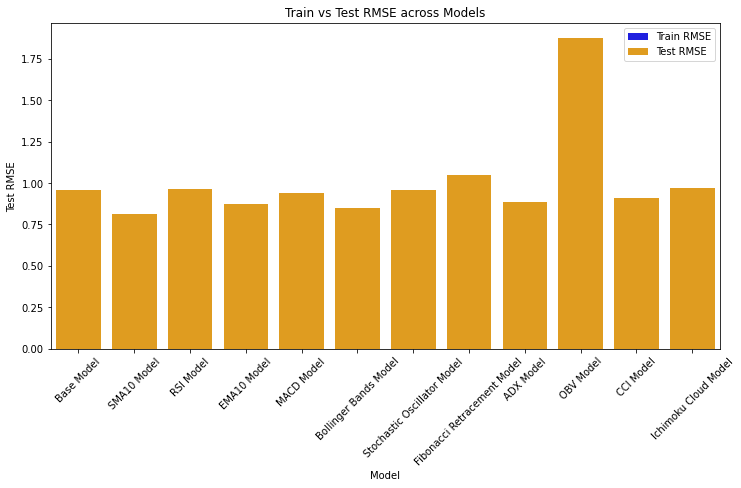

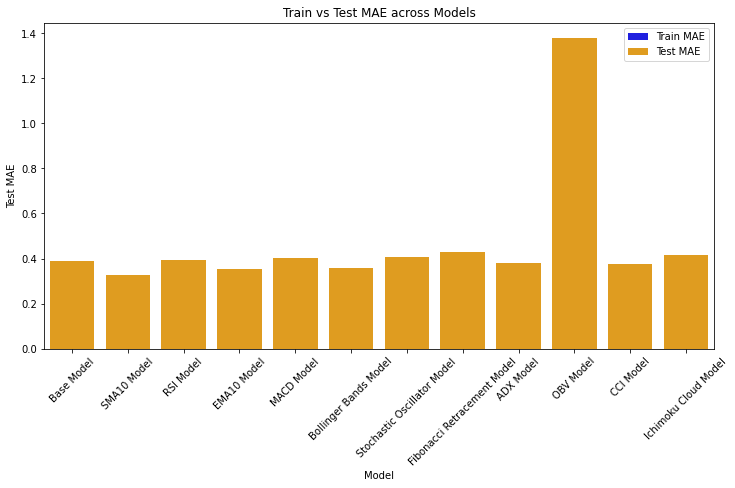

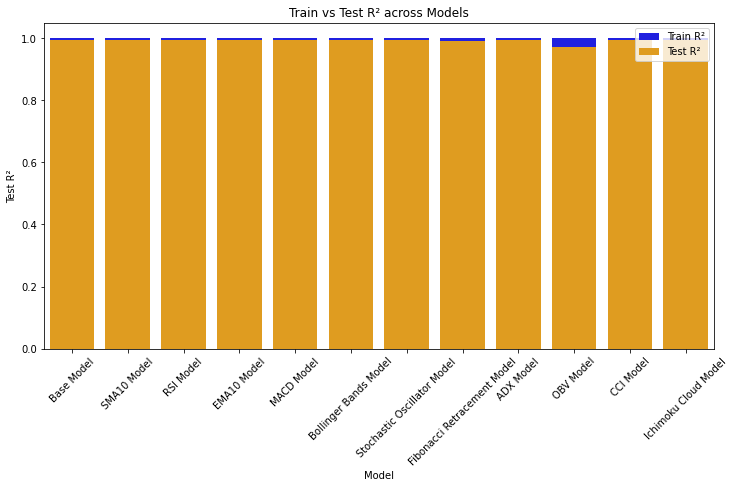

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the compiled results
results_df = pd.read_csv('compiled_model_performance_metrics.csv')

# 1. Performance Overview: Compare RMSE, MAE, R² across models

# Plot RMSE for Training and Testing Data
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Train RMSE', data=results_df, color='blue', label='Train RMSE')
sns.barplot(x='Model', y='Test RMSE', data=results_df, color='orange', label='Test RMSE')
plt.xticks(rotation=45)
plt.title('Train vs Test RMSE across Models')
plt.legend()
plt.show()

# Plot MAE for Training and Testing Data
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Train MAE', data=results_df, color='blue', label='Train MAE')
sns.barplot(x='Model', y='Test MAE', data=results_df, color='orange', label='Test MAE')
plt.xticks(rotation=45)
plt.title('Train vs Test MAE across Models')
plt.legend()
plt.show()

# Plot R² for Training and Testing Data
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Train R²', data=results_df, color='blue', label='Train R²')
sns.barplot(x='Model', y='Test R²', data=results_df, color='orange', label='Test R²')
plt.xticks(rotation=45)
plt.title('Train vs Test R² across Models')
plt.legend()
plt.show()




# **Model Performance Analysis**

## **1. Overall Model Performance**
The Base Model provides a solid baseline with a Train RMSE of **0.3385** and a Test RMSE of **0.9581**, indicating the model explains over 99% of the variance in the training data (Train R² = **0.9991**) and approximately 99% in the testing data (Test R² = **0.9927**). However, room for improvement is evident, particularly in the testing performance.

## **2. Performance Improvement Over Base Model**
- **SMA10 Model**: This model outperforms the Base Model significantly, with a Test RMSE of **0.8120** and a Test R² of **0.9948**. The t-statistic of **4.9442** and a p-value of **0.0078** confirm that the SMA10 provides a statistically significant improvement over the Base Model, making it the best-performing model in this analysis.

- **EMA10 Model**: While the EMA10 Model also shows better performance than the Base Model (Test RMSE = **0.8733**, Test R² = **0.9940**), its improvement is not statistically significant (t-statistic = **1.9064**, p-value = **0.1293**).

- **Bollinger Bands Model**: This model performs well, with a Test RMSE of **0.8465** and Test R² of **0.9943**. However, similar to the EMA10 Model, the improvement is not statistically significant (t-statistic = **1.5264**, p-value = **0.2016**).

## **3. Models with Declined or Comparable Performance**
- **RSI Model**: This model shows a slight decline in performance with a Test RMSE of **0.9632** and Test R² of **0.9926**. The t-statistic of **-1.9178** and p-value of **0.1276** suggest that RSI did not improve the model's performance.

- **Fibonacci Retracement Model**: The Fibonacci Model performed worse than the Base Model, with a Test RMSE of **1.0456** and Test R² of **0.9913**. The t-statistic of **-2.1034** and p-value of **0.1033** indicate that this decline is noticeable but not statistically significant.

- **OBV Model**: The OBV Model has the highest Test RMSE of **1.8733** and the lowest Test R² of **0.9719** among all models, indicating a significant drop in performance. The t-statistic of **-1.5111** and p-value of **0.2053** suggest that OBV does not contribute positively to the model's predictive power.

- **MACD Model**: The MACD Model performs similarly to the Base Model, with a Test RMSE of **0.9379** and Test R² of **0.9930**. The t-statistic of **-2.1251** and p-value of **0.1008** indicate that this model does not offer significant improvements.

- **Ichimoku Cloud Model**: This model also shows performance comparable to the Base Model, with a Test RMSE of **0.9702** and Test R² of **0.9924**. The t-statistic of **-2.1536** and p-value of **0.0976** suggest that the Ichimoku Cloud model does not provide a statistically significant improvement.

- **ADX Model**: The ADX Model shows a slight improvement over the Base Model, with a Test RMSE of **0.8875** and Test R² of **0.9937**. However, the improvement is not statistically significant (t-statistic = **-2.3504**, p-value = **0.0785**).

- **CCI Model**: This model's performance is very similar to the Base Model, with a Test RMSE of **0.9092** and Test R² of **0.9934**. The t-statistic of **-1.3895** and p-value of **0.2370** suggest that CCI does not significantly change the model's performance.

## **4. Conclusion**
- **Best Performing Model**: The **SMA10 Model** is the standout performer, with statistically significant improvements over the Base Model in both Test RMSE and R².

- **Other Models**: Models like **EMA10, Bollinger Bands,** and **ADX** show potential but lack statistically significant improvements. Models like **Fibonacci Retracement, OBV,** and **Ichimoku Cloud** underperformed compared to the Base Model.